In [1]:
# Widen notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import libraries necessary
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from time import time
import datetime
from IPython.display import display
import re
%matplotlib inline
import psycopg2
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('mode.chained_assignment', None)
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm # import statsmodels 
from pylab import hist, show, xticks
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the messages dataset

messages = pd.read_csv(r'/Users/lisafan/Desktop/BBT/bbt_messages_2017_2020.csv', low_memory = False)

Note that this table only includes outbound messages, and does not include inbound messages.

# Initial Data Exploration and Cleaning

In [15]:
messages['outbound_message_created_at'] = pd.to_datetime(messages['outbound_message_created_at']) # Change message timestamp to datetime format
messages['subscriber_zip_code'] = messages['subscriber_zip_code'].fillna(-1) # Fill NAs in order to convert to integers
messages['subscriber_zip_code'] = messages['subscriber_zip_code'].astype(int).astype(str).str.zfill(5) # Pad zip codes with 0s
messages['subscriber_zip_code'] = messages['subscriber_zip_code'].replace('000-1', np.nan) # Fill NAs again
messages['year'] = messages['outbound_message_created_at'].dt.year

In [16]:
messages.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17349502 entries, 0 to 17349501
Data columns (total 28 columns):
message_id                        17349496 non-null object
outbound_message_created_at       17349502 non-null datetime64[ns]
outbound_message_body             17349502 non-null object
outbound_message_partner_id       17324867 non-null object
message_type                      17349502 non-null object
subscriber_id                     17349502 non-null object
created_at                        17349502 non-null object
signedup_at                       17303389 non-null object
deactivated_at                    1792884 non-null object
carrier_name                      17347170 non-null object
subscriber_zip_code               16584159 non-null object
subscriber_city                   16584159 non-null object
timezone_default_offset           16584159 non-null float64
timezone_name                     16584159 non-null object
subscriber_state                  16584159 non-null

In [18]:
messages_by_year = pd.DataFrame(messages.groupby('year')['message_type'].value_counts(normalize = True))
messages_by_year.to_csv(r'/Users/lisafan/Desktop/BBT/messages_by_year.csv', index=True)  

Of BBT's outgoing messages in 2020:
- 46% are Normal (content messages sent by the system based on DOB) - I think these are also referred to as Program messages
- 40% are Scheduled (messages sent by partners with info about local events, based on age and zip code)
- 9% are National (scheduled messages sent to subscribers by BBT, including those who did not provide their zip code)
- 3% are Signup (messages sent to subscribers during signup)
- 1% are Survey (links to surveys sent to subscribers)

# Timing of Messages

## Adjust message timestamp data to reflect local time zones

In [18]:
min_date = messages['outbound_message_created_at'].dt.date.min()
max_date = messages['outbound_message_created_at'].dt.date.max()

print('The outbound messages dataset includes text messages from {} to {}.'.format(min_date, max_date))

The outbound messages dataset includes text messages from 2017-04-10 to 2020-04-03.


In [19]:
messages['timezone_default_offset'].value_counts()

-7.000     6873451
-5.000     5039110
-6.000     3299401
-8.000     1348150
-9.000       20356
-10.000       3576
-4.000         115
Name: timezone_default_offset, dtype: int64

In [20]:
# Cities in Arizona
pd.DataFrame(messages[(messages['subscriber_state']) == 'Arizona']['subscriber_city'].value_counts().sort_index())

,subscriber_city
Ajo,199
Amado,196
Apache Junction,7571
Arizona City,1672
Ash Fork,220
Avondale,32001
Bagdad,1022
Bapchule,536
Black Canyon City,625
Blue Gap,408


In [21]:
navajo = ['Cameron', 'Chinle', 'Fort Defiance', 'Kayenta', 'Leupp', 'Many Farms', 'Pinon', 'Saint Michaels', 'Tonalea', 'Tuba City', 'Window Rock'] # Cities in Navajo Nation

In [22]:
# Label time zones

conditions = [messages['timezone_default_offset'] == -4,
              messages['timezone_default_offset'] == -5, 
              messages['timezone_default_offset'] == -6,  
              (messages['timezone_default_offset'] == -7) & (messages['subscriber_state'] != 'Arizona'),
              (messages['timezone_default_offset'] == -7) & (messages['subscriber_state'] == 'Arizona') & (messages['subscriber_city'].isin(navajo)),
              (messages['timezone_default_offset'] == -7) & (messages['subscriber_state'] == 'Arizona') & (messages['subscriber_city'].isin(navajo) == False),
              messages['timezone_default_offset'] == -8,
              messages['timezone_default_offset'] == -9,
              messages['timezone_default_offset'] == -10]

choices = ['Atlantic', 'Eastern', 'Central', 'Mountain', 'Mountain', 'Arizona', 'Pacific', 'Alaska', 'Hawaii']

messages['timezone'] = np.select(conditions, choices, default ='')
messages

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_youngest_child,dob_oldest_child,scheduled_message_id,year,timezone
0,6e92ae11-f983-479f-8e9c-2b689368954d,2017-05-03 15:11:30.588685,Invalid zipcode. Kindly check your zipcode and...,00000000-0000-0000-0000-000000000002,signup,53e4abdd-308a-4cfc-a6fc-410c89a28d2d,2017-05-03 14:30:08.345377,2017-05-03 14:30:08.345377,NaN,AT&T Wireless,11096,Inwood,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2015-06-06,2015-06-06,NaN,2017,Eastern
1,57c0ec0e-f812-4b45-a33a-213f4663f1c2,2017-05-09 16:34:15.603110,Is this zipcode correct? If yes reply with 'Y...,00000000-0000-0000-0000-000000000002,signup,f328ee46-398c-422f-aa55-4816caeae06e,2017-05-09 16:31:26.230154,2017-05-09 16:31:26.230154,NaN,"T-Mobile USA, Inc.",11219,Brooklyn,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2014-06-23,2014-06-23,NaN,2017,Eastern
2,17d99d4d-137a-4317-b4d8-a63a4690fc93,2017-05-04 18:40:41.904659,"If you care for a young child, Bright by Text ...",f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaN,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central
3,ffb5de23-d828-4e3a-becf-8b10b80cefba,2017-05-04 18:45:12.364195,Unrecognized date of birth format. Please res...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaN,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central
4,bc56c5c2-c5b2-4a95-bfd5-a284661e7052,2017-05-04 18:39:17.856495,KLRN welcomes you to Bright by Text! Expect 2 ...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaN,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17349497,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 22:05:25.285664,Are you worried about paying rent or utilities...,b6a20a01-a55e-481c-9878-7c0ce616374a,scheduled,ef99f698-0fce-46af-8a36-d6fb1e3019f3,2020-01-09 23:50:28.983049,2020-01-09 23:50:28.983049,NaN,US Cellular Corp.,53726,Madison,-6.000,America/Chicago,Wisconsin,Web SignUp,activated,English,NaN,Wisconsin Public Television,2019-04-17 19:52:45.009641,True,Wisconsin,1.000,2017-07-30,2017-07-30,14d3b7e6-0af2-4065-9168-72241a26e25e,2020,Central
17349498,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 22:05:25.463028,Are you worried about paying rent or utilities...,b6a20a01-a55e-481c-9878-7c0ce616374a,scheduled,efa04d9a-bf9e-469f-825a-452fcc0e5754,2019-07-17 23:00:55.830226,2019-07-17 23:05:59.405609,NaN,Verizon Wireless,54311,Green Bay,-6.000,America/Chicago,Wisconsin,Text SignUp,activated,English,NaN,Wisconsin Public Television,2019-04-17 19:52:45.009641,True,Wisconsin,2.000,2014-10-18,2017-08-18,14d3b7e6-0af2-4065-9168-72241a26e25e,2020,Central
17349499,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 2

In [23]:
dst_dict = {
             'Eastern': [pd.Timestamp('2017-11-05T06'), pd.Timestamp('2018-03-11T07'), pd.Timestamp('2018-11-04T06'), 
                         pd.Timestamp('2019-03-10T07'), pd.Timestamp('2019-11-03T06'), pd.Timestamp('2020-03-08T07')],
             'Central': [pd.Timestamp('2017-11-05T07'), pd.Timestamp('2018-03-11T08'), pd.Timestamp('2018-11-04T07'), 
                         pd.Timestamp('2019-03-10T08'), pd.Timestamp('2019-11-03T07'), pd.Timestamp('2020-03-08T08')],
             'Mountain': [pd.Timestamp('2017-11-05T08'), pd.Timestamp('2018-03-11T09'), pd.Timestamp('2018-11-04T08'), 
                         pd.Timestamp('2019-03-10T09'), pd.Timestamp('2019-11-03T08'), pd.Timestamp('2020-03-08T09')],
             'Pacific': [pd.Timestamp('2017-11-05T09'), pd.Timestamp('2018-03-11T10'), pd.Timestamp('2018-11-04T09'), 
                         pd.Timestamp('2019-03-10T10'), pd.Timestamp('2019-11-03T09'), pd.Timestamp('2020-03-08T10')],
             'Alaska': [pd.Timestamp('2017-11-05T10'), pd.Timestamp('2018-03-11T11'), pd.Timestamp('2018-11-04T10'), 
                         pd.Timestamp('2019-03-10T11'), pd.Timestamp('2019-11-03T10'), pd.Timestamp('2020-03-08T11')],
            }

In [24]:
# Puerto Rico (timezone_default_offset = -4) and Hawaii (timezone_default_offset = -10) do not change their clocks for Daylight Savings. 
# Arizona also does not change their clocks for Daylight Savings, with the exception of the Navajo Nation.

def dst(row):
    if row['timezone'] in ['Atlantic', 'Arizona', 'Hawaii', '']:
        return row['timezone_default_offset']
    elif ((row['outbound_message_created_at'] < dst_dict[row['timezone']][0]) | \
          (dst_dict[row['timezone']][1] <= row['outbound_message_created_at'] < dst_dict[row['timezone']][2]) | \
          (dst_dict[row['timezone']][3] <= row['outbound_message_created_at'] < dst_dict[row['timezone']][4]) | \
          (row['outbound_message_created_at'] >= dst_dict[row['timezone']][5])):
        return row['timezone_default_offset'] + 1
    else: 
        return row['timezone_default_offset']

In [25]:
messages['timezone_default_offset_adj'] = messages.apply(dst, axis=1)

In [26]:
messages

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_youngest_child,dob_oldest_child,scheduled_message_id,year,timezone,timezone_default_offset_adj
0,6e92ae11-f983-479f-8e9c-2b689368954d,2017-05-03 15:11:30.588685,Invalid zipcode. Kindly check your zipcode and...,00000000-0000-0000-0000-000000000002,signup,53e4abdd-308a-4cfc-a6fc-410c89a28d2d,2017-05-03 14:30:08.345377,2017-05-03 14:30:08.345377,NaN,AT&T Wireless,11096,Inwood,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2015-06-06,2015-06-06,NaN,2017,Eastern,-4.000
1,57c0ec0e-f812-4b45-a33a-213f4663f1c2,2017-05-09 16:34:15.603110,Is this zipcode correct? If yes reply with 'Y...,00000000-0000-0000-0000-000000000002,signup,f328ee46-398c-422f-aa55-4816caeae06e,2017-05-09 16:31:26.230154,2017-05-09 16:31:26.230154,NaN,"T-Mobile USA, Inc.",11219,Brooklyn,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2014-06-23,2014-06-23,NaN,2017,Eastern,-4.000
2,17d99d4d-137a-4317-b4d8-a63a4690fc93,2017-05-04 18:40:41.904659,"If you care for a young child, Bright by Text ...",f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaN,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-5.000
3,ffb5de23-d828-4e3a-becf-8b10b80cefba,2017-05-04 18:45:12.364195,Unrecognized date of birth format. Please res...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaN,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-5.000
4,bc56c5c2-c5b2-4a95-bfd5-a284661e7052,2017-05-04 18:39:17.856495,KLRN welcomes you to Bright by Text! Expect 2 ...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaN,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17349497,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 22:05:25.285664,Are you worried about paying rent or utilities...,b6a20a01-a55e-481c-9878-7c0ce616374a,scheduled,ef99f698-0fce-46af-8a36-d6fb1e3019f3,2020-01-09 23:50:28.983049,2020-01-09 23:50:28.983049,NaN,US Cellular Corp.,53726,Madison,-6.000,America/Chicago,Wisconsin,Web SignUp,activated,English,NaN,Wisconsin Public Television,2019-04-17 19:52:45.009641,True,Wisconsin,1.000,2017-07-30,2017-07-30,14d3b7e6-0af2-4065-9168-72241a26e25e,2020,Central,-5.000
17349498,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 22:05:25.463028,Are you worried about paying rent or utilities...,b6a20a01-a55e-481c-9878-7c0ce616374a,scheduled,efa04d9a-bf9e-469f-825a-452fcc0e5754,2019-07-17 23:00:55.830226,2019-07-17 23:05:59.405609,NaN,Verizon Wireless,54311,Green Bay,-6.000,America/Chicago,Wisconsin,Text SignUp,activated,English,NaN,Wisconsin Public Television,2019-04-17 19:52:45.009641,True,Wisconsin,2.000,2014-10-18,2017-08-18,14d3b7e6-0af2-4065-9168-72241a26e2

In [23]:
# Download intermediate dataset

messages.to_csv(r'/Users/lisafan/Desktop/BBT/bbt_messages_staging.csv', index=False)  

In [28]:
# Load intermediate dataset

messages = pd.read_csv(r'/Users/lisafan/Desktop/BBT/bbt_messages_staging.csv', low_memory = False)

In [29]:
# Data cleaning

messages['outbound_message_created_at'] = pd.to_datetime(messages['outbound_message_created_at']) # Change message timestamp to datetime format
messages['signedup_at'] = pd.to_datetime(messages['signedup_at']) # Change signup timestamp to datetime format
messages['deactivated_at'] = pd.to_datetime(messages['deactivated_at']) # Change deactivation timestamp to datetime format
messages['created_at'] = pd.to_datetime(messages['created_at']) # Change created at timestamp to datetime format
messages['dob_youngest_child'] = pd.to_datetime(messages['dob_youngest_child'], errors = 'coerce') # Change DOB of youngest child to datetime format
messages['dob_oldest_child'] = pd.to_datetime(messages['dob_oldest_child'], errors = 'coerce') # Change DOB of oldest child to datetime format
messages['subscriber_zip_code'] = messages['subscriber_zip_code'].fillna(-1) # Fill NAs in order to convert to integers
messages['subscriber_zip_code'] = messages['subscriber_zip_code'].astype(int).astype(str).str.zfill(5) # Pad zip codes with 0s
messages['subscriber_zip_code'] = messages['subscriber_zip_code'].replace('000-1', np.nan) # Fill NAs again

In [30]:
# Adjust time stamps for timezones

messages['timezone_default_offset_adj'] = pd.to_timedelta(messages['timezone_default_offset_adj'],'h')
messages['outbound_message_created_at_adj'] = messages['outbound_message_created_at'] + messages['timezone_default_offset_adj']
messages['deactivated_at_adj'] = messages['deactivated_at'] + messages['timezone_default_offset_adj']
messages['created_at_adj'] = messages['created_at'] + messages['timezone_default_offset_adj']
messages

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_oldest_child,dob_youngest_child,scheduled_message_id,year,timezone,timezone_default_offset_adj,outbound_message_created_at_adj,deactivated_at_adj,created_at_adj
0,6e92ae11-f983-479f-8e9c-2b689368954d,2017-05-03 15:11:30.588685,Invalid zipcode. Kindly check your zipcode and...,00000000-0000-0000-0000-000000000002,signup,53e4abdd-308a-4cfc-a6fc-410c89a28d2d,2017-05-03 14:30:08.345377,2017-05-03 14:30:08.345377,NaT,AT&T Wireless,11096,Inwood,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2015-06-06,2015-06-06,NaN,2017,Eastern,-1 days +20:00:00,2017-05-03 11:11:30.588685,NaT,2017-05-03 10:30:08.345377
1,57c0ec0e-f812-4b45-a33a-213f4663f1c2,2017-05-09 16:34:15.603110,Is this zipcode correct? If yes reply with 'Y...,00000000-0000-0000-0000-000000000002,signup,f328ee46-398c-422f-aa55-4816caeae06e,2017-05-09 16:31:26.230154,2017-05-09 16:31:26.230154,NaT,"T-Mobile USA, Inc.",11219,Brooklyn,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2014-06-23,2014-06-23,NaN,2017,Eastern,-1 days +20:00:00,2017-05-09 12:34:15.603110,NaT,2017-05-09 12:31:26.230154
2,17d99d4d-137a-4317-b4d8-a63a4690fc93,2017-05-04 18:40:41.904659,"If you care for a young child, Bright by Text ...",f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:40:41.904659,NaT,2017-05-04 13:39:17.165132
3,ffb5de23-d828-4e3a-becf-8b10b80cefba,2017-05-04 18:45:12.364195,Unrecognized date of birth format. Please res...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:45:12.364195,NaT,2017-05-04 13:39:17.165132
4,bc56c5c2-c5b2-4a95-bfd5-a284661e7052,2017-05-04 18:39:17.856495,KLRN welcomes you to Bright by Text! Expect 2 ...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:39:17.856495,NaT,2017-05-04 13:39:17.165132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17349497,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 22:05:25.285664,Are you worried about paying rent or utilities...,b6a20a01-a55e-481c-9878-7c0ce616374a,scheduled,ef99f698-0fce-46af-8a36-d6fb1e3019f3,2020-01-09 23:50:28.983049,2020-01-09 23:50:28.983049,NaT,US Cellular Corp.,53726,Madison,-6.000,America/Chicago,Wisconsin,Web SignUp,activated,English,NaN,Wisconsin Public Television,2019-04-17 19:52:45.009641,True,Wisconsin,1.000,2017-07-30,2017-07-30,14d3b7e6-0af2-4065-9168-72241a26e25e,2020,Central,-1 days +19:00:00,2020-04-02 17:05:25.285664,NaT,2020-01-09 18:50:28.983049
17349

In [31]:
messages['outbound_message_created_at_adj'] = pd.to_datetime(messages['outbound_message_created_at_adj']) 
day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
messages['outbound_message_created_at_day'] = messages['outbound_message_created_at_adj'].dt.dayofweek.map(day_dict)
messages

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_oldest_child,dob_youngest_child,scheduled_message_id,year,timezone,timezone_default_offset_adj,outbound_message_created_at_adj,deactivated_at_adj,created_at_adj,outbound_message_created_at_day
0,6e92ae11-f983-479f-8e9c-2b689368954d,2017-05-03 15:11:30.588685,Invalid zipcode. Kindly check your zipcode and...,00000000-0000-0000-0000-000000000002,signup,53e4abdd-308a-4cfc-a6fc-410c89a28d2d,2017-05-03 14:30:08.345377,2017-05-03 14:30:08.345377,NaT,AT&T Wireless,11096,Inwood,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2015-06-06,2015-06-06,NaN,2017,Eastern,-1 days +20:00:00,2017-05-03 11:11:30.588685,NaT,2017-05-03 10:30:08.345377,Wednesday
1,57c0ec0e-f812-4b45-a33a-213f4663f1c2,2017-05-09 16:34:15.603110,Is this zipcode correct? If yes reply with 'Y...,00000000-0000-0000-0000-000000000002,signup,f328ee46-398c-422f-aa55-4816caeae06e,2017-05-09 16:31:26.230154,2017-05-09 16:31:26.230154,NaT,"T-Mobile USA, Inc.",11219,Brooklyn,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2014-06-23,2014-06-23,NaN,2017,Eastern,-1 days +20:00:00,2017-05-09 12:34:15.603110,NaT,2017-05-09 12:31:26.230154,Tuesday
2,17d99d4d-137a-4317-b4d8-a63a4690fc93,2017-05-04 18:40:41.904659,"If you care for a young child, Bright by Text ...",f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:40:41.904659,NaT,2017-05-04 13:39:17.165132,Thursday
3,ffb5de23-d828-4e3a-becf-8b10b80cefba,2017-05-04 18:45:12.364195,Unrecognized date of birth format. Please res...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:45:12.364195,NaT,2017-05-04 13:39:17.165132,Thursday
4,bc56c5c2-c5b2-4a95-bfd5-a284661e7052,2017-05-04 18:39:17.856495,KLRN welcomes you to Bright by Text! Expect 2 ...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:39:17.856495,NaT,2017-05-04 13:39:17.165132,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17349497,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 22:05:25.285664,Are you worried about paying rent or utilities...,b6a20a01-a55e-481c-9878-7c0ce616374a,scheduled,ef99f698-0fce-46af-8a36-d6fb1e3019f3,2020-01-09 23:50:28.983049,2020-01-09 23:50:28.983049,NaT,US Cellular Corp.,53726,Madison,-6.000,America/Chicago,Wisconsin,Web SignUp,activated,English,NaN,Wisconsin Public Television,2019-04-17 19:52:45.009641,True,Wisconsin,1.000,2017-07-30,2017-07-30,14d3b7e6-0af2-4065-9168-72241a26e25e,2020,Central,

## Analyze Day of Week Sent

In [32]:
messages.groupby('year')['outbound_message_created_at_day'].value_counts(normalize = True)

year  outbound_message_created_at_day
2017  Tuesday                           0.163
      Friday                            0.157
      Wednesday                         0.148
      Monday                            0.143
      Thursday                          0.136
      Saturday                          0.133
      Sunday                            0.121
2018  Friday                            0.153
      Tuesday                           0.148
      Thursday                          0.147
      Wednesday                         0.147
      Monday                            0.144
      Saturday                          0.135
      Sunday                            0.126
2019  Friday                            0.154
      Thursday                          0.150
      Tuesday                           0.149
      Wednesday                         0.149
      Saturday                          0.142
      Monday                            0.141
      Sunday                            0.

The most common day messages are sent seems to vary over time. Messages are sent more frequently during the weekdays.

In [33]:
messages_day = pd.DataFrame(messages.groupby('year')['outbound_message_created_at_day'].value_counts(normalize = True))
messages_day.to_csv(r'/Users/lisafan/Desktop/BBT/messages_day.csv', index=True)  

In [34]:
messages.groupby('message_type')['outbound_message_created_at_day'].value_counts(normalize = True)

message_type  outbound_message_created_at_day
national      Thursday                          0.366
              Tuesday                           0.237
              Friday                            0.139
              Saturday                          0.131
              Monday                            0.070
              Wednesday                         0.057
normal        Wednesday                         0.145
              Monday                            0.144
              Tuesday                           0.143
              Saturday                          0.143
              Thursday                          0.143
              Friday                            0.142
              Sunday                            0.141
scheduled     Wednesday                         0.196
              Friday                            0.183
              Thursday                          0.182
              Monday                            0.160
              Tuesday               

In [35]:
messages_by_day = pd.DataFrame(messages.groupby('message_type')['outbound_message_created_at_day'].value_counts(normalize = True))
messages_by_day.to_csv(r'/Users/lisafan/Desktop/BBT/messages_by_day.csv', index=True)  

In [36]:
# 2020 only

messages[messages['year'] == 2020].groupby('message_type')['outbound_message_created_at_day'].value_counts(normalize = True)

message_type  outbound_message_created_at_day
national      Thursday                          0.616
              Tuesday                           0.255
              Monday                            0.130
normal        Wednesday                         0.151
              Thursday                          0.150
              Sunday                            0.141
              Friday                            0.141
              Monday                            0.140
              Tuesday                           0.140
              Saturday                          0.137
scheduled     Wednesday                         0.251
              Friday                            0.158
              Monday                            0.141
              Thursday                          0.128
              Tuesday                           0.128
              Saturday                          0.101
              Sunday                            0.092
signup        Wednesday             

In [37]:
messages_by_day_2020 = pd.DataFrame(messages[messages['year'] == 2020].groupby('message_type')['outbound_message_created_at_day'].value_counts(normalize = True))
messages_by_day_2020.to_csv(r'/Users/lisafan/Desktop/BBT/messages_by_day_2020.csv', index=True)  

## Analyze Time of Day Sent

In [38]:
messages['outbound_message_created_at_hour'] = messages['outbound_message_created_at_adj'].dt.hour
messages['outbound_message_created_at_hour'].value_counts(normalize = True)

11.000   0.438
15.000   0.184
14.000   0.107
17.000   0.054
13.000   0.042
10.000   0.038
12.000   0.036
16.000   0.036
9.000    0.020
18.000   0.017
8.000    0.009
7.000    0.008
19.000   0.005
6.000    0.002
20.000   0.002
21.000   0.001
22.000   0.001
23.000   0.001
5.000    0.000
0.000    0.000
1.000    0.000
4.000    0.000
3.000    0.000
2.000    0.000
Name: outbound_message_created_at_hour, dtype: float64

In [39]:
messages_by_time = pd.DataFrame(messages['outbound_message_created_at_hour'].value_counts(normalize = True))
messages_by_time.to_csv(r'/Users/lisafan/Desktop/BBT/messages_by_time.csv', index=True)  

In [40]:
messages[messages['year'] == 2020]['outbound_message_created_at_hour'].value_counts(normalize = True)

11.000   0.630
15.000   0.090
14.000   0.048
12.000   0.048
13.000   0.041
16.000   0.033
10.000   0.026
17.000   0.023
9.000    0.017
7.000    0.016
8.000    0.010
18.000   0.006
19.000   0.006
6.000    0.003
20.000   0.001
21.000   0.000
22.000   0.000
23.000   0.000
5.000    0.000
0.000    0.000
2.000    0.000
4.000    0.000
1.000    0.000
3.000    0.000
Name: outbound_message_created_at_hour, dtype: float64

The majority of messages are sent at 11am local time.

In [41]:
messages_by_time_2020 = pd.DataFrame(messages[messages['year'] == 2020]['outbound_message_created_at_hour'].value_counts(normalize = True))
messages_by_time_2020.to_csv(r'/Users/lisafan/Desktop/BBT/messages_by_time_2020.csv', index=True)  

In [42]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.3f}'.format
pd.DataFrame(messages.groupby('message_type')['outbound_message_created_at_hour'].value_counts(normalize = True))

outbound_message_created_at_hour
message_type outbound_message_created_at_hour                                  
national     13.000                                                       0.182
             14.000                                                       0.181
             12.000                                                       0.164
             15.000                                                       0.148
             11.000                                                       0.099
             16.000                                                       0.082
             10.000                                                       0.057
             17.000                                                       0.042
             9.000                                                        0.019
             18.000                                                       0.015
             19.000                                                       0.003
             20.000                                                       0.002
             21.000                                                       0.002
             23.000                                                       0.002
             22.000                                                       0.002
             0.000                                                        0.001
             1.000                                                        0.000
             8.000                                                        0.000
             7.000                                                        0.000
             6.000                                                        0.000
normal       11.000                                                       0.541
             15.000                                                       0.195
             14.000                                                       0.109
             17.000                                                       0.060
             16.000                                                       0.029
             13.000                                                       0.027
             18.000                                                       0.017
             10.000                                                       0.012
             12.000                                                       0.007
             9.000                                                        0.001
             8.000                                                        0.000
             6.000                                                        0.000
             19.000                                                       0.000
             5.000                                                        0.000
             7.000                                                        0.000
             20.000                                                       0.000
             21.000                                                       0.000
             22.000                                                       0.000
             23.000                                                       0.000
             4.000                                                        0.000
             0.000                                                        0.000
             1.000                                                        0.000
             3.000                                                        0.000
             2.000                                                        0.000
scheduled    10.000                                                       0.161
             11.000                                                       0.149
             12.000                                                       0.131
             15.000                                                       0.108
             9.000                             

In [43]:
messages_by_time_type = pd.DataFrame(messages.groupby('message_type')['outbound_message_created_at_hour'].value_counts(normalize = True))
messages_by_time_type.to_csv(r'/Users/lisafan/Desktop/BBT/messages_by_time_type.csv', index=True)  

In [44]:
pd.DataFrame(messages[messages['year'] == 2020].groupby('message_type')['outbound_message_created_at_hour'].value_counts(normalize = True))

outbound_message_created_at_hour
message_type outbound_message_created_at_hour                                  
national     15.000                                                       0.213
             14.000                                                       0.199
             13.000                                                       0.178
             16.000                                                       0.137
             12.000                                                       0.116
             17.000                                                       0.073
             11.000                                                       0.052
             18.000                                                       0.023
             10.000                                                       0.007
             9.000                                                        0.000
             8.000                                                        0.000
normal       11.000                                                       1.000
             12.000                                                       0.000
             10.000                                                       0.000
             13.000                                                       0.000
             9.000                                                        0.000
             8.000                                                        0.000
scheduled    12.000                                                       0.150
             10.000                                                       0.134
             11.000                                                       0.106
             9.000                                                        0.092
             7.000                                                        0.091
             15.000                                                       0.090
             14.000                                                       0.074
             13.000                                                       0.053
             17.000                                                       0.053
             8.000                                                        0.052
             16.000                                                       0.050
             19.000                                                       0.030
             6.000                                                        0.015
             18.000                                                       0.010
             20.000                                                       0.000
             4.000                                                        0.000
signup       11.000                                                       0.113
             13.000                                                       0.099
             12.000                                                       0.088
             10.000                                                       0.078
             9.000                                                        0.073
             14.000                                                       0.070
             15.000                                                       0.063
             8.000                                                        0.063
             16.000                                                       0.056
             17.000                                                       0.046
             7.000                                                        0.041
             18.000                                                       0.038
             20.000                                                       0.034
             19.000                                                       0.033
             21.000                                                       0.024
             22.000                            

- National messages: 20% of national messages are sent at noon local time. 98% of all national messages are sent between 9am-5pm local time. In 2020, national messages were most frequently sent at 3pm local time. Essentially all national messages were sent between 10am-6pm local time in 2020.
- Normal messages: Over 50% of all normal messages are all sent at 11am local time. All normal messages were sent at 11am local time in 2020.
- Scheduled messages: Scheduled messages are sent most frequently at 10am and 11am. 77% are sent between 9am-3pm local time. In 2020, scheduled messages were sent most frequently at noon.
- Signup messages: Signup messages are sent at a variety of times, most often sent between 9am-noon. In 2020, signup messages were sent most frequently between 11am-1pm.
- Survey messages: Survey messages are mostly sent at 3pm local time. In 2020, they were all sent at 3pm local time.

In [45]:
messages_by_time_type_2020 = pd.DataFrame(messages[messages['year'] == 2020].groupby('message_type')['outbound_message_created_at_hour'].value_counts(normalize = True))
messages_by_time_type_2020.to_csv(r'/Users/lisafan/Desktop/BBT/messages_by_time_type_2020.csv', index=True)  

## Analyzing Frequency of Messages

In [46]:
messages['days_since_deactivated'] = messages['deactivated_at_adj'] - messages['created_at_adj']
messages['days_since_signup'] = pd.Timestamp('2020-04-03T02') - messages['created_at_adj']
messages['subscriber_days'] = messages[['days_since_deactivated', 'days_since_signup']].min(axis = 1)
messages['subscriber_days'] = messages['subscriber_days'] / datetime.timedelta(days = 1)
messages['subscriber_weeks'] = messages['subscriber_days'] / 7
messages

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_oldest_child,dob_youngest_child,scheduled_message_id,year,timezone,timezone_default_offset_adj,outbound_message_created_at_adj,deactivated_at_adj,created_at_adj,outbound_message_created_at_day,outbound_message_created_at_hour,days_since_deactivated,days_since_signup,subscriber_days,subscriber_weeks
0,6e92ae11-f983-479f-8e9c-2b689368954d,2017-05-03 15:11:30.588685,Invalid zipcode. Kindly check your zipcode and...,00000000-0000-0000-0000-000000000002,signup,53e4abdd-308a-4cfc-a6fc-410c89a28d2d,2017-05-03 14:30:08.345377,2017-05-03 14:30:08.345377,NaT,AT&T Wireless,11096,Inwood,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2015-06-06,2015-06-06,NaN,2017,Eastern,-1 days +20:00:00,2017-05-03 11:11:30.588685,NaT,2017-05-03 10:30:08.345377,Wednesday,11.000,NaT,1065 days 15:29:51.654623,1065.646,152.235
1,57c0ec0e-f812-4b45-a33a-213f4663f1c2,2017-05-09 16:34:15.603110,Is this zipcode correct? If yes reply with 'Y...,00000000-0000-0000-0000-000000000002,signup,f328ee46-398c-422f-aa55-4816caeae06e,2017-05-09 16:31:26.230154,2017-05-09 16:31:26.230154,NaT,"T-Mobile USA, Inc.",11219,Brooklyn,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2014-06-23,2014-06-23,NaN,2017,Eastern,-1 days +20:00:00,2017-05-09 12:34:15.603110,NaT,2017-05-09 12:31:26.230154,Tuesday,12.000,NaT,1059 days 13:28:33.769846,1059.562,151.366
2,17d99d4d-137a-4317-b4d8-a63a4690fc93,2017-05-04 18:40:41.904659,"If you care for a young child, Bright by Text ...",f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:40:41.904659,NaT,2017-05-04 13:39:17.165132,Thursday,13.000,NaT,1064 days 12:20:42.834868,1064.514,152.073
3,ffb5de23-d828-4e3a-becf-8b10b80cefba,2017-05-04 18:45:12.364195,Unrecognized date of birth format. Please res...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:45:12.364195,NaT,2017-05-04 13:39:17.165132,Thursday,13.000,NaT,1064 days 12:20:42.834868,1064.514,152.073
4,bc56c5c2-c5b2-4a95-bfd5-a284661e7052,2017-05-04 18:39:17.856495,KLRN welcomes you to Bright by Text! Expect 2 ...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:39:17.856495,NaT,2017-05-04 13:39:17.165132,Thursday,13.000,NaT,1064 days 12:20:42.834868,1064.514,152.073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17349497,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,2020-04-02 22:05:25.285664,Are you worried about paying rent or util

In [47]:
# Messages per subscriber

messages_per_subscriber = messages[messages['subscriber_zip_code'].notnull()].groupby('subscriber_id').agg({'message_id':'count', 'subscriber_weeks': 'max'}).reset_index()
messages_per_subscriber.columns = ['subscriber_id', 'message_count', 'subscriber_weeks']
messages_per_subscriber['messages_per_subscriber_per_week'] = messages_per_subscriber['message_count'] / messages_per_subscriber['subscriber_weeks']
messages_per_subscriber

,subscriber_id,message_count,subscriber_weeks,messages_per_subscriber_per_week
0,000018d6-c7fe-4b3c-8bf7-8502e4ae2d9b,293,87.167,3.361
1,00005a8a-477e-46c6-82f9-e4678760599c,48,19.982,2.402
2,0000661e-1c9c-4dde-a9f6-b2a8291142fd,123,34.373,3.578
3,00007706-12cc-48e8-a732-649de7ec8b50,141,24.241,5.817
4,000128d7-701e-4919-ad93-fd2ef3a5f69d,224,56.927,3.935
...,...,...,...,...
91362,fffb736f-0273-4f16-8151-8ded8a8b1aa5,165,30.347,5.437
91363,fffc68c4-e8b7-4060-bce9-e6b6ca74b00c,303,105.521,2.871
91364,fffd402d-4bbd-4322-8389-a159f1dfa038,40,6.251,6.398
91365,fffde26d-0880-4ca0-a67e-46dcd77f4dab,468,145.546,3.215


## Analyzing Scheduled Message Tags

In [48]:
# Load scheduled message tags

scheduled_message_tags = pd.read_csv(r'/Users/lisafan/Desktop/BBT/scheduled_message_tags.csv', low_memory = False)

In [49]:
scheduled_message_tags['scheduled_message_tag'].value_counts()

knowledge of parenting and child development    1504
event                                           1458
education resource                              1390
social connections                              1375
social and emotional competence of children     1147
parental resilience                              622
concrete support in times of need                599
health resource                                  397
COVID Resources                                  324
other community referral resource                133
public service announcement                       93
Name: scheduled_message_tag, dtype: int64

In [50]:
# Add columns based on scheduled_message_tags

tags = ['event', 'social connections', 'knowledge of parenting and child development', 'education resource', 'social and emotional competence of children', 'parental resilience', 'concrete support in times of need', 'health resource', 'other community referral resource', 'public service announcement', 'COVID Resources']

for tag in tags:
    scheduled_message_tags['tag_' + tag] = np.where(scheduled_message_tags['scheduled_message_tag'] == tag, 1, 0)

scheduled_message_tags.columns = scheduled_message_tags.columns.str.replace(' ', '_')

In [51]:
# Indicator variables identifying tags associated with each scheduled message id

cols = [x for x in scheduled_message_tags.columns if x.startswith('tag')]
scheduled_message_tags = scheduled_message_tags.groupby('scheduled_message_id')[cols].max().reset_index()
scheduled_message_tags

,scheduled_message_id,tag_event,tag_social_connections,tag_knowledge_of_parenting_and_child_development,tag_education_resource,tag_social_and_emotional_competence_of_children,tag_parental_resilience,tag_concrete_support_in_times_of_need,tag_health_resource,tag_other_community_referral_resource,tag_public_service_announcement,tag_COVID_Resources
0,001b4ae3-c19e-4dd8-b7e2-529b7411e3a4,0,0,0,0,0,0,0,0,0,0,0
1,003aeb99-97cc-4780-8b65-ce36b528d751,1,1,0,0,0,0,0,0,0,0,0
2,0050f2aa-ab52-427c-9ae7-c5b9f7b20003,0,0,0,0,0,0,0,0,0,0,0
3,005a8b12-b24a-4b53-9f5c-cf5ced7ee9bf,0,0,0,0,0,0,0,0,0,0,0
4,00605ee1-e361-4d18-8549-6a57b5e678f8,1,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3308,ffc65780-de08-47cc-8aee-1850399d8c80,1,1,1,1,0,1,1,1,0,0,0
3309,ffda5fb4-837c-4151-9866-ebc5b8a295d0,1,1,1,1,1,0,0,0,0,0,0
3310,ffea8c8a-16ec-4a29-b4d5-2256395b3185,1,1,1,1,1,0,0,0,0,0,0
3311,fff49fa7-6414-41de-a023-108fb5f62847,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# Join tag information to main messages table

messages = messages.merge(scheduled_message_tags, how = 'left', left_on = 'scheduled_message_id', right_on = 'scheduled_message_id', left_index = True, right_index = False)
messages[cols] = messages[cols].fillna(0)
messages

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_oldest_child,dob_youngest_child,scheduled_message_id,year,timezone,timezone_default_offset_adj,outbound_message_created_at_adj,deactivated_at_adj,created_at_adj,outbound_message_created_at_day,outbound_message_created_at_hour,days_since_deactivated,days_since_signup,subscriber_days,subscriber_weeks,tag_event,tag_social_connections,tag_knowledge_of_parenting_and_child_development,tag_education_resource,tag_social_and_emotional_competence_of_children,tag_parental_resilience,tag_concrete_support_in_times_of_need,tag_health_resource,tag_other_community_referral_resource,tag_public_service_announcement,tag_COVID_Resources
nan,6e92ae11-f983-479f-8e9c-2b689368954d,2017-05-03 15:11:30.588685,Invalid zipcode. Kindly check your zipcode and...,00000000-0000-0000-0000-000000000002,signup,53e4abdd-308a-4cfc-a6fc-410c89a28d2d,2017-05-03 14:30:08.345377,2017-05-03 14:30:08.345377,NaT,AT&T Wireless,11096,Inwood,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2015-06-06,2015-06-06,NaN,2017,Eastern,-1 days +20:00:00,2017-05-03 11:11:30.588685,NaT,2017-05-03 10:30:08.345377,Wednesday,11.000,NaT,1065 days 15:29:51.654623,1065.646,152.235,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,57c0ec0e-f812-4b45-a33a-213f4663f1c2,2017-05-09 16:34:15.603110,Is this zipcode correct? If yes reply with 'Y...,00000000-0000-0000-0000-000000000002,signup,f328ee46-398c-422f-aa55-4816caeae06e,2017-05-09 16:31:26.230154,2017-05-09 16:31:26.230154,NaT,"T-Mobile USA, Inc.",11219,Brooklyn,-5.000,America/New_York,New York,Text SignUp,activated,English,NaN,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2014-06-23,2014-06-23,NaN,2017,Eastern,-1 days +20:00:00,2017-05-09 12:34:15.603110,NaT,2017-05-09 12:31:26.230154,Tuesday,12.000,NaT,1059 days 13:28:33.769846,1059.562,151.366,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,17d99d4d-137a-4317-b4d8-a63a4690fc93,2017-05-04 18:40:41.904659,"If you care for a young child, Bright by Text ...",f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:40:41.904659,NaT,2017-05-04 13:39:17.165132,Thursday,13.000,NaT,1064 days 12:20:42.834868,1064.514,152.073,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,ffb5de23-d828-4e3a-becf-8b10b80cefba,2017-05-04 18:45:12.364195,Unrecognized date of birth format. Please res...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc.",78251,San Antonio,-6.000,America/Chicago,Texas,Text SignUp,activated,English,NaN,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,2.000,2014-09-02,2016-09-03,NaN,2017,Central,-1 days +19:00:00,2017-05-04 13:45:12.364195,NaT,2017-05-04 13:39:17.165132,Thursday,13.000,NaT,1064 days 12:20:42.834868,1064.514,152.073,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,bc56c5c2-c5b2-4a95-bfd5-a284661e7052,2017-05-04 18:39:17.856495,KLRN welcomes you to Bright by Text! Expect 2 ...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 18:39:17.165132,2017-05-04 18:39:17.165132,NaT,"T-Mobile USA, Inc

In [53]:
# Print some overall messages stats for analysis

messages_count = messages['message_id'].count()
scheduled_messages_count = messages[messages['message_type'] == 'scheduled']['message_id'].count()
messages_2020_count = messages[messages['year'] == 2020]['message_id'].count()
scheduled_messages_2020_count = messages[(messages['message_type'] == 'scheduled') & (messages['year'] == 2020)]['message_id'].count()

print("There were {:,.0f} messages total, and {:,.0f} messages in 2020. There were {:,.0f} scheduled messages total, and {:,.0f} scheduled messages in 2020".format(messages_count, messages_2020_count, scheduled_messages_count, scheduled_messages_2020_count))

There were 17,349,496 messages total, and 3,354,337 messages in 2020. There were 2,174,541 scheduled messages total, and 558,830 scheduled messages in 2020


In [54]:
messages[cols].sum().reset_index().to_csv(r'/Users/lisafan/Desktop/BBT/message_tags_breakdown.csv', index=True)  
messages[messages['year'] == 2020][cols].sum().reset_index().to_csv(r'/Users/lisafan/Desktop/BBT/message_tags_breakdown_2020.csv', index=True)  

# Subscriber regression

## Add Deactivation and STOP as variables

In [56]:
messages['stop'] = np.where(messages['subscriber_deactivation_method'] == 'STOP', 1, 0)
messages['deactivated'] = np.where(messages['subscriber_status'] == 'deactivated', 1, 0)
staging_cols = ['stop', 'deactivated']

d = {'stop': 'max', 'deactivated': 'max'}

staging = messages.groupby('subscriber_id')[staging_cols].agg(d).reset_index()
staging

,subscriber_id,stop,deactivated
0,000018d6-c7fe-4b3c-8bf7-8502e4ae2d9b,1,1
1,00005a8a-477e-46c6-82f9-e4678760599c,1,1
2,0000661e-1c9c-4dde-a9f6-b2a8291142fd,0,0
3,00007706-12cc-48e8-a732-649de7ec8b50,0,0
4,000128d7-701e-4919-ad93-fd2ef3a5f69d,0,0
...,...,...,...
111601,fffc68c4-e8b7-4060-bce9-e6b6ca74b00c,0,0
111602,fffd402d-4bbd-4322-8389-a159f1dfa038,0,0
111603,fffdbcab-63d2-4158-9743-bbb138036518,0,1
111604,fffde26d-0880-4ca0-a67e-46dcd77f4dab,0,0


## Add in number of children and age of children as variables

In [57]:
children = messages
children['age_oldest_child'] = (np.minimum(pd.Timestamp('2020-04-03T02') - children['dob_oldest_child'], children['deactivated_at_adj'] - children['dob_oldest_child'])) / pd.to_timedelta(1, unit='D')
children['age_oldest_child'] = children['age_oldest_child'] / 365.25

children['age_youngest_child'] = (np.minimum(pd.Timestamp('2020-04-03T02') - children['dob_youngest_child'], children['deactivated_at_adj'] - children['dob_youngest_child'])) / pd.to_timedelta(1, unit='D')
children['age_youngest_child'] = children['age_youngest_child'] / 365.25

children['age_oldest_child_at_signup'] = (children['created_at_adj'] - children['dob_oldest_child']) / pd.to_timedelta(1, unit='D')
children['age_oldest_child_at_signup'] = children['age_oldest_child_at_signup'] / 365.25

children['age_youngest_child_at_signup'] = (children['created_at_adj'] - children['dob_youngest_child']) / pd.to_timedelta(1, unit='D')
children['age_youngest_child_at_signup'] = children['age_youngest_child_at_signup'] / 365.25

children = children.groupby('subscriber_id')[['children_count', 'age_youngest_child', 'age_oldest_child', 'age_youngest_child_at_signup', 'age_oldest_child_at_signup']].agg('max').reset_index()
children

,subscriber_id,children_count,age_youngest_child,age_oldest_child,age_youngest_child_at_signup,age_oldest_child_at_signup
0,000018d6-c7fe-4b3c-8bf7-8502e4ae2d9b,1.000,2.745,2.745,1.075,1.075
1,00005a8a-477e-46c6-82f9-e4678760599c,1.000,1.718,1.718,1.335,1.335
2,0000661e-1c9c-4dde-a9f6-b2a8291142fd,1.000,2.377,2.377,1.718,1.718
3,00007706-12cc-48e8-a732-649de7ec8b50,2.000,2.223,4.627,1.759,4.163
4,000128d7-701e-4919-ad93-fd2ef3a5f69d,1.000,1.629,1.629,0.538,0.538
...,...,...,...,...,...,...
111601,fffc68c4-e8b7-4060-bce9-e6b6ca74b00c,1.000,4.419,4.419,2.397,2.397
111602,fffd402d-4bbd-4322-8389-a159f1dfa038,1.000,3.880,3.880,3.760,3.760
111603,fffdbcab-63d2-4158-9743-bbb138036518,nan,nan,nan,nan,nan
111604,fffde26d-0880-4ca0-a67e-46dcd77f4dab,1.000,3.239,3.239,0.450,0.450


## Analyze Correlations

In [71]:
a = children[(children['children_count'] > 0) & (children['age_youngest_child_at_signup'] > -0.75) & (children['age_youngest_child_at_signup'] <= 10)].merge(messages_per_subscriber[messages_per_subscriber['subscriber_weeks'] >= 1], how = 'inner', left_on = 'subscriber_id', right_on = 'subscriber_id', left_index = True, right_index = False)
subscribers = a.merge(staging, how = 'inner', left_on = 'subscriber_id', right_on = 'subscriber_id', left_index = True, right_index = False)
subscribers
subscriber_reg = subscribers.drop(columns = ['subscriber_id', 'message_count', 'subscriber_weeks', 'age_youngest_child', 'age_oldest_child', 'stop'])
subscriber_reg.corr()

,children_count,age_youngest_child_at_signup,age_oldest_child_at_signup,messages_per_subscriber_per_week,deactivated
children_count,1.000,-0.100,0.325,0.379,0.007
age_youngest_child_at_signup,-0.100,1.000,0.869,-0.412,-0.011
age_oldest_child_at_signup,0.325,0.869,1.000,-0.220,-0.008
messages_per_subscriber_per_week,0.379,-0.412,-0.220,1.000,-0.050
deactivated,0.007,-0.011,-0.008,-0.050,1.000


In [72]:
subscriber_reg.to_csv(r'/Users/lisafan/Desktop/BBT/subscriber_reg.csv', index=False)  

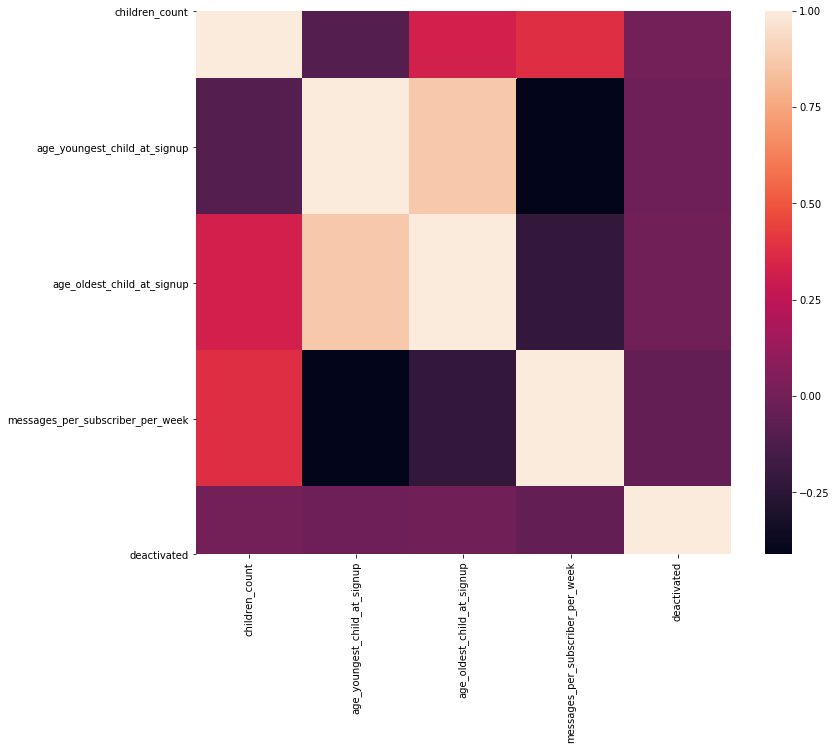

In [73]:
# feature correlation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(subscriber_reg.corr(), ax=ax)
plt.show()

# Comparing Active vs. Deactivated Subscribers

## Active Subscribers Overview

In [74]:
children_count_median = subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 0)]['children_count'].median()
children_count_mean = subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 0)]['children_count'].mean()
only_child_median = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].median()
only_child_mean = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].mean()
youngest_child_median = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].median()
youngest_child_mean = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].mean()
oldest_child_median = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child'].median()
oldest_child_mean = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child'].mean()
only_child_median_signup = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].median()
only_child_mean_signup = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].mean()
youngest_child_median_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].median()
youngest_child_mean_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].mean()
oldest_child_median_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child_at_signup'].median()
oldest_child_mean_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child_at_signup'].mean()
messages_per_day_median = subscribers[(subscribers['subscriber_weeks'] >= 1) & (subscribers['deactivated'] == 0)]['messages_per_subscriber_per_week'].median()
messages_per_day_mean = subscribers[(subscribers['subscriber_weeks'] >= 1) & (subscribers['deactivated'] == 0)]['messages_per_subscriber_per_week'].mean()
weeks_subscribed_median = subscribers[(subscribers['deactivated'] == 0)]['subscriber_weeks'].median()
weeks_subscribed_mean = subscribers[(subscribers['deactivated'] == 0)]['subscriber_weeks'].mean()

print("The median number of children a subscriber has is {}, while the average is {}".format(children_count_median, children_count_mean))
print("The median age of the youngest child a subscriber has is {}, while the average is {}".format(youngest_child_median, youngest_child_mean))
print("The median age of the oldest child a subscriber has is {}, while the average is {}".format(oldest_child_median, oldest_child_mean))
print("For subscribers with only one child, the median age of the child is {}, while the average is {}".format(only_child_median, only_child_mean))
print("The median age at signup of the youngest child a subscriber has is {}, while the average is {}".format(youngest_child_median_signup, youngest_child_mean_signup))
print("The median age at signup of the oldest child a subscriber has is {}, while the average is {}".format(oldest_child_median_signup, oldest_child_mean_signup))
print("For subscribers with only one child, the median age at signup of the child is {}, while the average is {}".format(only_child_median_signup, only_child_mean_signup))
print("Subscribers get a median of {} messages per week, and an average of {} messages per week".format(messages_per_day_median, messages_per_day_mean))
print("Subscribers have been subscribed for a median of {} weeks and an average of {} weeks".format(weeks_subscribed_median, weeks_subscribed_mean))

The median number of children a subscriber has is 1.0, while the average is 1.138178024054256
The median age of the youngest child a subscriber has is 2.6778462240474563, while the average is 2.9854635362022455
The median age of the oldest child a subscriber has is 5.637462924937258, while the average is 5.720085063431584
For subscribers with only one child, the median age of the child is 3.7278120009126168, while the average is 3.948814996537985
The median age at signup of the youngest child a subscriber has is 1.458198688339671, while the average is 1.8846679690163248
The median age at signup of the oldest child a subscriber has is 4.442540282065272, while the average is 4.619289496245665
For subscribers with only one child, the median age at signup of the child is 1.9970081100681294, while the average is 2.4479264716141227
Subscribers get a median of 3.1620447573749098 messages per week, and an average of 3.2633402503680915 messages per week
Subscribers have been subscribed for a me

## Deactivated Subscribers Overview

In [75]:
children_count_median = subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 1)]['children_count'].median()
children_count_mean = subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 1)]['children_count'].mean()
only_child_median = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].median()
only_child_mean = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].mean()
youngest_child_median = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].median()
youngest_child_mean = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child'].mean()
oldest_child_median = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child'].median()
oldest_child_mean = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child'].mean()
only_child_median_signup = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].median()
only_child_mean_signup = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].mean()
youngest_child_median_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].median()
youngest_child_mean_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_youngest_child_at_signup'].mean()
oldest_child_median_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child_at_signup'].median()
oldest_child_mean_signup = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)]['age_oldest_child_at_signup'].mean()
messages_per_day_median = subscribers[(subscribers['subscriber_weeks'] >= 1) & (subscribers['deactivated'] == 1)]['messages_per_subscriber_per_week'].median()
messages_per_day_mean = subscribers[(subscribers['subscriber_weeks'] >= 1) & (subscribers['deactivated'] == 1)]['messages_per_subscriber_per_week'].mean()
weeks_subscribed_median = subscribers[(subscribers['deactivated'] == 1)]['subscriber_weeks'].median()
weeks_subscribed_mean = subscribers[(subscribers['deactivated'] == 1)]['subscriber_weeks'].mean()

print("The median number of children a subscriber has is {}, while the average is {}".format(children_count_median, children_count_mean))
print("The median age of the youngest child a subscriber has is {}, while the average is {}".format(youngest_child_median, youngest_child_mean))
print("The median age of the oldest child a subscriber has is {}, while the average is {}".format(oldest_child_median, oldest_child_mean))
print("For subscribers with only one child, the median age of the child is {}, while the average is {}".format(only_child_median, only_child_mean))
print("The median age at signup of the youngest child a subscriber has is {}, while the average is {}".format(youngest_child_median_signup, youngest_child_mean_signup))
print("The median age at signup of the oldest child a subscriber has is {}, while the average is {}".format(oldest_child_median_signup, oldest_child_mean_signup))
print("For subscribers with only one child, the median age at signup of the child is {}, while the average is {}".format(only_child_median_signup, only_child_mean_signup))
print("Subscribers get a median of {} messages per week, and an average of {} messages per week".format(messages_per_day_median, messages_per_day_mean))
print("Subscribers have been subscribed for a median of {} weeks and an average of {} weeks".format(weeks_subscribed_median, weeks_subscribed_mean))

The median number of children a subscriber has is 1.0, while the average is 1.145805082247509
The median age of the youngest child a subscriber has is 1.9182150440209964, while the average is 2.212135120390604
The median age of the oldest child a subscriber has is 4.825383564896158, while the average is 4.977582660014771
For subscribers with only one child, the median age of the child is 2.930752534410823, while the average is 3.2136518829553395
The median age at signup of the youngest child a subscriber has is 1.2577584627388965, while the average is 1.6060346282915814
The median age at signup of the oldest child a subscriber has is 4.178792164013329, while the average is 4.371482167915741
For subscribers with only one child, the median age at signup of the child is 2.0626308559723965, while the average is 2.4253080716291606
Subscribers get a median of 2.8592384982698156 messages per week, and an average of 3.018931410598368 messages per week
Subscribers have been subscribed for a med

## Frequency of Messages Received

### Deactivated Subscribers

In [105]:
messages_per_subscriber_deactivated = messages[(messages['deactivated'] == 1) & (messages['subscriber_zip_code'].notnull()) & (messages['subscriber_weeks'] >= 1)].groupby('subscriber_id').agg({'message_id':'count', 'subscriber_weeks': 'max'}).reset_index()
messages_per_subscriber_deactivated.columns = ['subscriber_id', 'message_count', 'subscriber_weeks']
messages_per_subscriber_deactivated['messages_per_subscriber_per_week'] = messages_per_subscriber_deactivated['message_count'] / messages_per_subscriber_deactivated['subscriber_weeks']
messages_per_subscriber_deactivated

,subscriber_id,message_count,subscriber_weeks,messages_per_subscriber_per_week
0,000018d6-c7fe-4b3c-8bf7-8502e4ae2d9b,293,87.167,3.361
1,00005a8a-477e-46c6-82f9-e4678760599c,48,19.982,2.402
2,00079148-20c5-44a2-aa40-8f50133e3b19,5,45.009,0.111
3,000c4b49-bd1d-490b-b606-6e093b85db21,6,1.002,5.986
4,000d4d56-cf0c-44e1-9bd8-90be987e3e7e,12,2.530,4.743
...,...,...,...,...
17167,ffecc895-565b-46ba-bbeb-0b47a884cb16,2,19.847,0.101
17168,ffef1d4b-0af4-4dd7-97d4-d3b6af5c54d3,39,69.173,0.564
17169,fff6f597-fa30-4457-addc-f1335fec3eb6,326,112.329,2.902
17170,fff87ce8-ff4b-497d-b188-204322b2c62b,16,3.976,4.024


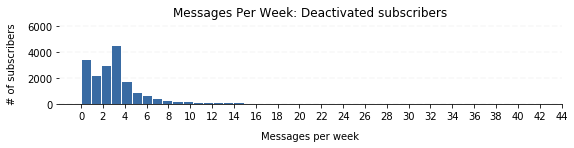

In [106]:
ax = messages_per_subscriber_deactivated.hist(column='messages_per_subscriber_per_week', bins=44, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Messages Per Week: Deactivated subscribers")

    # Set x-axis label
    x.set_xlabel("Messages per week", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(0,45,2))

### Active Subscribers

In [107]:
messages_per_subscriber_active = messages[(messages['deactivated'] != 1) & (messages['subscriber_zip_code'].notnull()) & (messages['subscriber_weeks'] >= 1)].groupby('subscriber_id').agg({'message_id':'count', 'subscriber_weeks': 'max'}).reset_index()
messages_per_subscriber_active.columns = ['subscriber_id', 'message_count', 'subscriber_weeks']
messages_per_subscriber_active['messages_per_subscriber_per_week'] = messages_per_subscriber_active['message_count'] / messages_per_subscriber_active['subscriber_weeks']
messages_per_subscriber_active

,subscriber_id,message_count,subscriber_weeks,messages_per_subscriber_per_week
0,0000661e-1c9c-4dde-a9f6-b2a8291142fd,123,34.373,3.578
1,00007706-12cc-48e8-a732-649de7ec8b50,141,24.241,5.817
2,000128d7-701e-4919-ad93-fd2ef3a5f69d,224,56.927,3.935
3,000166bf-c4ef-4ef2-a503-abbc44c34ec1,217,66.309,3.273
4,00027e72-dd22-426c-8dc6-9185b5e348c0,35,105.764,0.331
...,...,...,...,...
71390,fffb736f-0273-4f16-8151-8ded8a8b1aa5,165,30.347,5.437
71391,fffc68c4-e8b7-4060-bce9-e6b6ca74b00c,303,105.521,2.871
71392,fffd402d-4bbd-4322-8389-a159f1dfa038,40,6.251,6.398
71393,fffde26d-0880-4ca0-a67e-46dcd77f4dab,468,145.546,3.215


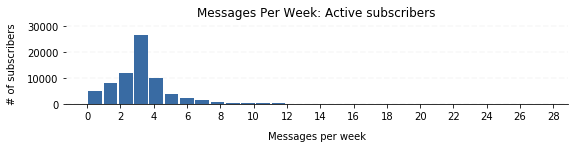

In [108]:
ax = messages_per_subscriber_active.hist(column='messages_per_subscriber_per_week', bins=30, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Messages Per Week: Active subscribers")

    # Set x-axis label
    x.set_xlabel("Messages per week", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(0,30,2))

## Number of Weeks Subscribed

### Active Subscribers

In [113]:
weeks_per_subscriber_active = messages[(messages['deactivated'] != 1) & (messages['subscriber_zip_code'].notnull())].groupby('subscriber_id')['subscriber_weeks'].max().reset_index()
weeks_per_subscriber_active.columns = ['subscriber_id', 'subscriber_weeks']
weeks_per_subscriber_active

,subscriber_id,subscriber_weeks
0,0000661e-1c9c-4dde-a9f6-b2a8291142fd,34.373
1,00007706-12cc-48e8-a732-649de7ec8b50,24.241
2,000128d7-701e-4919-ad93-fd2ef3a5f69d,56.927
3,000166bf-c4ef-4ef2-a503-abbc44c34ec1,66.309
4,00027e72-dd22-426c-8dc6-9185b5e348c0,105.764
...,...,...
72093,fffb736f-0273-4f16-8151-8ded8a8b1aa5,30.347
72094,fffc68c4-e8b7-4060-bce9-e6b6ca74b00c,105.521
72095,fffd402d-4bbd-4322-8389-a159f1dfa038,6.251
72096,fffde26d-0880-4ca0-a67e-46dcd77f4dab,145.546


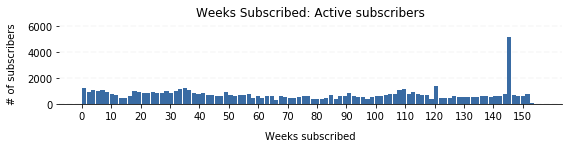

In [114]:
ax = weeks_per_subscriber_active.hist(column='subscriber_weeks', bins=100, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Weeks Subscribed: Active subscribers")

    # Set x-axis label
    x.set_xlabel("Weeks subscribed", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(0,160,10))

### Deactivated Subscribers

In [115]:
weeks_per_subscriber_deactivated = messages[(messages['deactivated'] == 1) & (messages['subscriber_zip_code'].notnull())].groupby('subscriber_id')['subscriber_weeks'].max().reset_index()
weeks_per_subscriber_deactivated.columns = ['subscriber_id', 'subscriber_weeks']
weeks_per_subscriber_deactivated

,subscriber_id,subscriber_weeks
0,000018d6-c7fe-4b3c-8bf7-8502e4ae2d9b,87.167
1,00005a8a-477e-46c6-82f9-e4678760599c,19.982
2,00079148-20c5-44a2-aa40-8f50133e3b19,45.009
3,000c4b49-bd1d-490b-b606-6e093b85db21,1.002
4,000d4d56-cf0c-44e1-9bd8-90be987e3e7e,2.530
...,...,...
19264,ffecc895-565b-46ba-bbeb-0b47a884cb16,19.847
19265,ffef1d4b-0af4-4dd7-97d4-d3b6af5c54d3,69.173
19266,fff6f597-fa30-4457-addc-f1335fec3eb6,112.329
19267,fff87ce8-ff4b-497d-b188-204322b2c62b,3.976


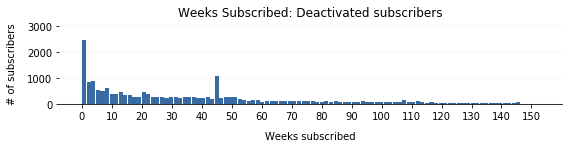

In [116]:
ax = weeks_per_subscriber_deactivated.hist(column='subscriber_weeks', bins=100, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Weeks Subscribed: Deactivated subscribers")

    # Set x-axis label
    x.set_xlabel("Weeks subscribed", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(0,160,10))

## Number of Children

In [119]:
subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 0)]['children_count'].value_counts().reset_index()

,index,children_count
0,1.000,62928
1,2.000,6599
2,3.000,1128
3,4.000,201
4,5.000,36
5,6.000,14
6,8.000,6
7,7.000,5
8,9.000,3
9,12.000,1


In [120]:
# Export to Excel

subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 0)]['children_count'].value_counts().reset_index().to_csv(r'/Users/lisafan/Desktop/BBT/children_count_active.csv', index=False)  

In [121]:
subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 1)]['children_count'].value_counts().reset_index()

,index,children_count
0,1.000,15004
1,2.000,1577
2,3.000,287
3,4.000,73
4,5.000,10
5,6.000,6
6,11.000,2
7,7.000,1
8,8.000,1


In [122]:
# Export to Excel

subscribers[(subscribers['children_count'] > 0) & (subscribers['deactivated'] == 1)]['children_count'].value_counts().reset_index().to_csv(r'/Users/lisafan/Desktop/BBT/children_count_deactivated.csv', index=False)  

### Active Subscribers

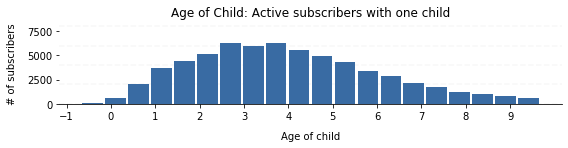

In [123]:
ax = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Child: Active subscribers with one child")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

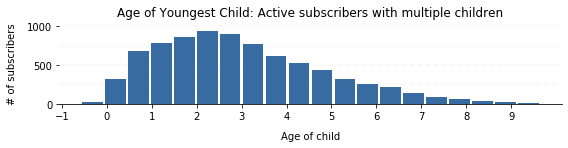

In [124]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Youngest Child: Active subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

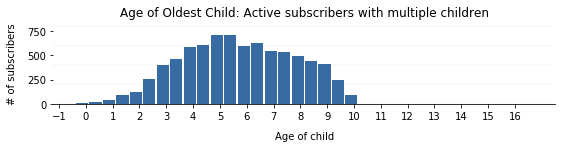

In [125]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_oldest_child', bins=34, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Oldest Child: Active subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,17))

### Deactivated Subscribers

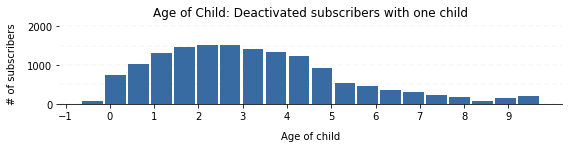

In [126]:
ax = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Child: Deactivated subscribers with one child")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

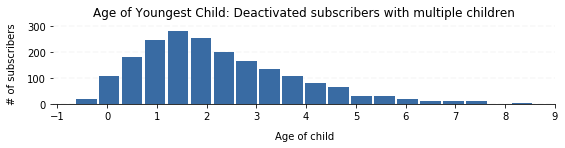

In [127]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Youngest Child: Deactivated subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

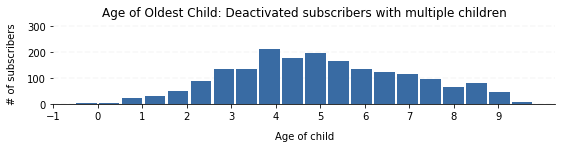

In [128]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['stop'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_oldest_child', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Oldest Child: Deactivated subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

## Age at Signup

### Active subscribers

## Find distribution of amount of time before deactivation

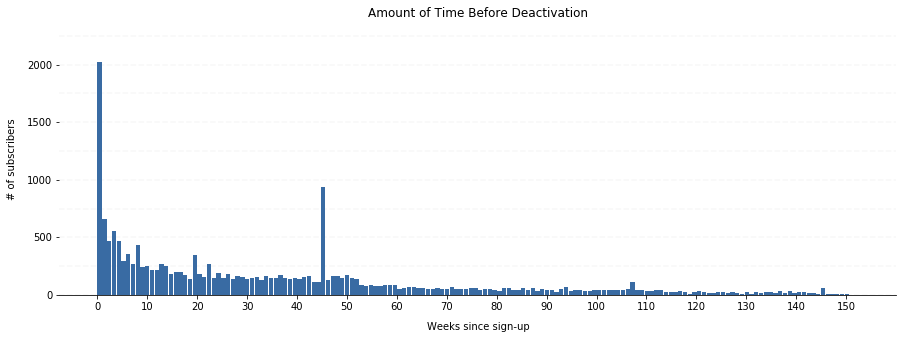

In [224]:
time_before_deactivation = messages[messages['stop'] == 1].groupby('subscriber_id')['subscriber_weeks'].max().reset_index()

ax = time_before_deactivation.hist(column='subscriber_weeks', bins=160, grid=False, figsize=(15,5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Amount of Time Before Deactivation")

    # Set x-axis label
    x.set_xlabel("Weeks since sign-up", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(0,160,10))

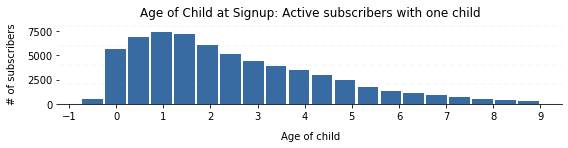

In [129]:
ax = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child_at_signup', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Child at Signup: Active subscribers with one child")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

## Analyze day of week last message before deactivation was sent (last 24 hours only)

In [221]:
messages_before_deactivation_24h['outbound_message_created_at_day'].value_counts(normalize = True)

Thursday    0.172
Tuesday     0.161
Wednesday   0.158
Saturday    0.151
Monday      0.134
Friday      0.129
Sunday      0.095
Name: outbound_message_created_at_day, dtype: float64

In [222]:
messages['outbound_message_created_at_day'].value_counts(normalize = True)

Thursday    0.165
Tuesday     0.154
Wednesday   0.146
Friday      0.146
Monday      0.141
Saturday    0.132
Sunday      0.117
Name: outbound_message_created_at_day, dtype: float64

In [223]:
pd.DataFrame(messages['outbound_message_created_at_day'].value_counts(normalize = True)).to_csv(r'/Users/lisafan/Desktop/BBT/day_of_week_overall.csv')  

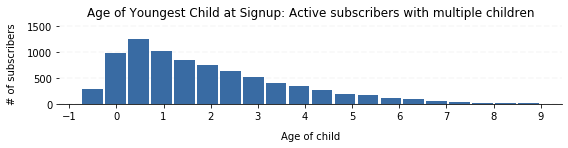

In [130]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child_at_signup', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Youngest Child at Signup: Active subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

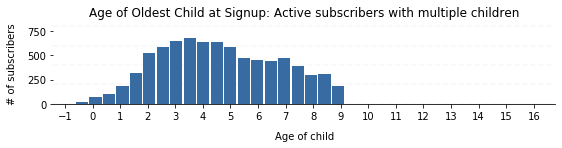

In [131]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 0) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_oldest_child_at_signup', bins=34, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Oldest Child at Signup: Active subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,17))

### Deactivated Subscribers

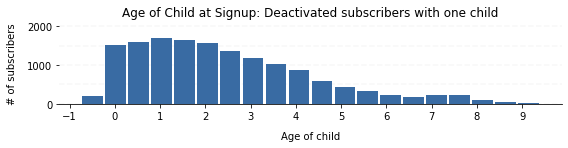

In [132]:
ax = subscribers[(subscribers['children_count'] == 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child_at_signup', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Child at Signup: Deactivated subscribers with one child")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

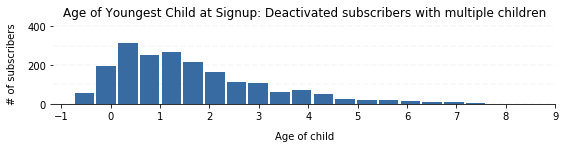

In [133]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['deactivated'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_youngest_child_at_signup', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Youngest Child at Signup: Deactivated subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

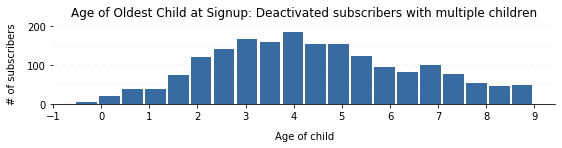

In [134]:
ax = subscribers[(subscribers['children_count'] > 1) & (subscribers['stop'] == 1) & (subscribers['age_youngest_child_at_signup'] >= -0.75) & (subscribers['age_youngest_child_at_signup'] <= 10)].hist(column='age_oldest_child_at_signup', bins=20, grid=False, figsize=(9,1.5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Age of Oldest Child at Signup: Deactivated subscribers with multiple children")

    # Set x-axis label
    x.set_xlabel("Age of child", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(-1,10))

## Types of messages received

In [135]:
types = ['normal', 'national', 'scheduled', 'survey']

for t in types:
    messages[t] = np.where(messages['message_type'] == t, 1, 0)

### Deactivated Subscribers

In [136]:
message_types_deactivated = messages[messages['deactivated'] == 1].groupby('subscriber_id')[types].max().reset_index()
message_types_deactivated

,subscriber_id,normal,national,scheduled,survey
0,000018d6-c7fe-4b3c-8bf7-8502e4ae2d9b,1,1,1,1
1,00005a8a-477e-46c6-82f9-e4678760599c,1,0,1,1
2,00079148-20c5-44a2-aa40-8f50133e3b19,1,0,1,0
3,00099cbd-14b0-4968-8590-3fb0339c999c,1,0,0,0
4,000c4b49-bd1d-490b-b606-6e093b85db21,1,0,1,0
...,...,...,...,...,...
35029,fff87ce8-ff4b-497d-b188-204322b2c62b,1,0,1,1
35030,fff9175e-082c-45d4-9630-c82a42988e96,1,0,0,0
35031,fffa314c-ac6f-4097-ab45-95089ba6af7a,0,0,0,0
35032,fffa4b42-920e-4104-91a6-e73c129566eb,1,0,1,1


In [137]:
message_types_deactivated.groupby(['normal', 'national', 'scheduled', 'survey']).count()

subscriber_id
normal national scheduled survey               
0      0        0         0               13394
                          1                 151
                1         0                  83
                          1                 165
       1        0         0                  86
                          1                  16
                1         0                 112
                          1                 168
1      0        0         0                5672
                          1                1032
                1         0                2004
                          1                2179
       1        0         0                 444
                          1                 764
                1         0                1219
                          1                7545

In [138]:
# Export to Excel
message_types_deactivated.groupby(['normal', 'national', 'scheduled', 'survey']).count().to_csv(r'/Users/lisafan/Desktop/BBT/message_types_deactivated.csv')  

In [139]:
message_types_active = messages[messages['deactivated'] != 1].groupby('subscriber_id')[types].max().reset_index()
message_types_active

,subscriber_id,normal,national,scheduled,survey
0,0000661e-1c9c-4dde-a9f6-b2a8291142fd,1,1,1,1
1,00007706-12cc-48e8-a732-649de7ec8b50,1,1,0,1
2,000128d7-701e-4919-ad93-fd2ef3a5f69d,1,1,1,1
3,000166bf-c4ef-4ef2-a503-abbc44c34ec1,1,1,1,1
4,00027e72-dd22-426c-8dc6-9185b5e348c0,0,1,1,1
...,...,...,...,...,...
76567,fffb736f-0273-4f16-8151-8ded8a8b1aa5,1,1,1,1
76568,fffc68c4-e8b7-4060-bce9-e6b6ca74b00c,1,1,1,1
76569,fffd402d-4bbd-4322-8389-a159f1dfa038,1,1,1,1
76570,fffde26d-0880-4ca0-a67e-46dcd77f4dab,1,1,1,1


In [140]:
message_types_active.groupby(['normal', 'national', 'scheduled', 'survey']).count()

subscriber_id
normal national scheduled survey               
0      0        0         0                 110
                          1                   8
                1         0                  10
                          1                  94
       1        0         0                 184
                          1                  28
                1         0                 480
                          1                1030
1      0        0         0                   2
                1         0                   2
       1        0         0                1951
                          1                3920
                1         0                1773
                          1               66980

## Scheduled message tags received

### Active Subscribers

In [169]:
d = {'deactivated': 'max'}
for col in cols:
    d[col] = ['max', 'sum']

subscribers_tags = messages.groupby('subscriber_id')[['deactivated'] + cols].agg(d).reset_index()

tag_list = []

for col in cols:
    tag_list.append(col + '_ind')
    tag_list.append(col + '_total')
    
subscribers_tags.columns = ['subscriber_id', 'deactivated'] + tag_list

tag_ind_cols = [col for col in subscribers_tags.columns if (('tag' in col) & ('ind' in col))]

subscribers_tags[subscribers_tags['deactivated'] != 1][tag_ind_cols].mean()

tag_event_ind                                          0.793
tag_social_connections_ind                             0.785
tag_knowledge_of_parenting_and_child_development_ind   0.910
tag_education_resource_ind                             0.888
tag_social_and_emotional_competence_of_children_ind    0.861
tag_parental_resilience_ind                            0.798
tag_concrete_support_in_times_of_need_ind              0.837
tag_health_resource_ind                                0.798
tag_other_community_referral_resource_ind              0.642
tag_public_service_announcement_ind                    0.562
tag_COVID_Resources_ind                                0.759
dtype: float64

In [171]:
# Export to Excel

pd.DataFrame(subscribers_tags[subscribers_tags['deactivated'] != 1][tag_ind_cols].mean()).to_csv(r'/Users/lisafan/Desktop/BBT/message_tag_ind_active.csv')  

In [172]:
tag_total_cols = [col for col in subscribers_tags.columns if (('tag' in col) & ('total' in col))]

subscribers_tags[subscribers_tags['deactivated'] != 1][tag_total_cols].sum()

tag_event_total                                           850376.000
tag_social_connections_total                              819383.000
tag_knowledge_of_parenting_and_child_development_total   1019850.000
tag_education_resource_total                              837161.000
tag_social_and_emotional_competence_of_children_total     649004.000
tag_parental_resilience_total                             394525.000
tag_concrete_support_in_times_of_need_total               405531.000
tag_health_resource_total                                 302486.000
tag_other_community_referral_resource_total               134917.000
tag_public_service_announcement_total                     114109.000
tag_COVID_Resources_total                                 121171.000
dtype: float64

In [173]:
# Export to Excel

pd.DataFrame(subscribers_tags[subscribers_tags['deactivated'] != 1][tag_total_cols].sum()).to_csv(r'/Users/lisafan/Desktop/BBT/message_tag_total_active.csv')  

In [174]:
total_messages = messages[messages['deactivated'] != 1]['message_type'].count()
total_scheduled_messages = messages[(messages['deactivated'] != 1) & (messages['message_type'] == 'scheduled')]['message_type'].count()

print("Active subscribers received {} total messages, and {} scheduled messages".format(total_messages, total_scheduled_messages))

Active subscribers received 15556750 total messages, and 1994546 scheduled messages


### Deactivated Subscribers

In [175]:
subscribers_tags[subscribers_tags['deactivated'] == 1][tag_ind_cols].mean()

tag_event_ind                                          0.195
tag_social_connections_ind                             0.190
tag_knowledge_of_parenting_and_child_development_ind   0.211
tag_education_resource_ind                             0.206
tag_social_and_emotional_competence_of_children_ind    0.185
tag_parental_resilience_ind                            0.141
tag_concrete_support_in_times_of_need_ind              0.141
tag_health_resource_ind                                0.121
tag_other_community_referral_resource_ind              0.125
tag_public_service_announcement_ind                    0.077
tag_COVID_Resources_ind                                0.029
dtype: float64

In [176]:
# Export to Excel

pd.DataFrame(subscribers_tags[subscribers_tags['deactivated'] == 1][tag_ind_cols].mean()).to_csv(r'/Users/lisafan/Desktop/BBT/message_tag_ind_deactivated.csv')  

In [177]:
subscribers_tags[subscribers_tags['deactivated'] == 1][tag_total_cols].sum()

tag_event_total                                          56761.000
tag_social_connections_total                             55379.000
tag_knowledge_of_parenting_and_child_development_total   54337.000
tag_education_resource_total                             51199.000
tag_social_and_emotional_competence_of_children_total    38927.000
tag_parental_resilience_total                            17503.000
tag_concrete_support_in_times_of_need_total              17228.000
tag_health_resource_total                                11743.000
tag_other_community_referral_resource_total               9422.000
tag_public_service_announcement_total                     4415.000
tag_COVID_Resources_total                                 2048.000
dtype: float64

In [178]:
# Export to Excel

pd.DataFrame(subscribers_tags[subscribers_tags['deactivated'] == 1][tag_total_cols].sum()).to_csv(r'/Users/lisafan/Desktop/BBT/message_tag_total_deactivated.csv')  

In [179]:
total_messages = messages[messages['deactivated'] == 1]['message_type'].count()
total_scheduled_messages = messages[(messages['deactivated'] == 1) & (messages['message_type'] == 'scheduled')]['message_type'].count()

print("Deactivated subscribers received {} total messages, and {} scheduled messages".format(total_messages, total_scheduled_messages))

Deactivated subscribers received 1792752 total messages, and 179995 scheduled messages


# Analyzing Subscriber Activity Prior to STOP

## Number of Subscribers each Message was Sent to

In [76]:
num_subscribers_sent = messages.groupby('outbound_message_body')['subscriber_id'].nunique()
num_subscribers_sent

outbound_message_body
\nLamentamos el error en el enlace a la encuesta. Por favor use este nuevo. ¡Gracias!                                                                               11
\n¡Visite Lunch Lizard para almuerzo gratis para niños de 0-18 años en su comunidad! Ver el programar de ubicaciones.                                                1
\n¡Visite el Lunch Lizard para comidas gratuitas para niños y actividades! Artes marciales hoy en la ruta de GJ y libros gratis cada semana.                         1
 Alergias a las comidas son comunes. Aprende a como reconocer reacciones alérgicas y como mantener a tu hijo/a seguro/a                                            265
 Alergias a las comidas son comunes. Aprende a como reconocer reacciones alérgicas y como mantener a tu hijo/a seguro/a bit.ly/2BFFTxT                             296
                                                                                                                                               

## Last Message Prior to Deactivation

In [77]:
deactivated = messages[messages['stop'] == 1] 
deactivated = deactivated[~deactivated['outbound_message_body'].str.contains('been unsubscribed', regex=False)] # Exclude messages confirming deactivation
deactivated = deactivated[~deactivated['outbound_message_body'].str.contains('ha sido cancelada', regex=False)]
messages_before_deactivation = deactivated[deactivated['outbound_message_created_at_adj'] < deactivated['deactivated_at_adj']]
messages_before_deactivation

max_indices = messages_before_deactivation.groupby('subscriber_id')['outbound_message_created_at_adj'].transform(max) == messages_before_deactivation['outbound_message_created_at_adj']
messages_before_deactivation = messages_before_deactivation[max_indices]
messages_before_deactivation

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_oldest_child,dob_youngest_child,scheduled_message_id,year,timezone,timezone_default_offset_adj,outbound_message_created_at_adj,deactivated_at_adj,created_at_adj,outbound_message_created_at_day,outbound_message_created_at_hour,days_since_deactivated,days_since_signup,subscriber_days,subscriber_weeks,tag_event,tag_social_connections,tag_knowledge_of_parenting_and_child_development,tag_education_resource,tag_social_and_emotional_competence_of_children,tag_parental_resilience,tag_concrete_support_in_times_of_need,tag_health_resource,tag_other_community_referral_resource,tag_public_service_announcement,tag_COVID_Resources,stop,deactivated,age_oldest_child,age_youngest_child,age_oldest_child_at_signup,age_youngest_child_at_signup
nan,7834d83a-6aab-47ba-a5b7-7340140ca22e,2017-05-04 02:05:23.438035,We’re working on creating text content for thi...,f92494a8-bcce-473f-a56e-0ae2515c827e,signup,07d195cc-bb3f-4ee9-8be2-0291dbd690c2,2017-05-04 02:00:22.714521,2017-05-04 02:00:22.714521,2018-04-30 14:46:56.269482,"T-Mobile USA, Inc.",34746,Kissimmee,-5.000,America/New_York,Florida,Text SignUp,deactivated,English,STOP,KLRN - San Antonio,2018-08-28 20:58:04.700242,True,Texas,nan,NaT,NaT,NaN,2017,Eastern,-1 days +20:00:00,2017-05-03 22:05:23.438035,2018-04-30 10:46:56.269482,2017-05-03 22:00:22.714521,Wednesday,22.000,361 days 12:46:33.554961,1065 days 03:59:37.285479,361.532,51.647,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,nan,nan,nan,nan
2618.000,8b0c78b1-93fc-4455-8ac3-65cf22cd0795,2017-05-05 19:00:22.919031,Success starts early! Come to the free All the...,00000000-0000-0000-0000-000000000002,scheduled,5b6a2aa0-57cd-4bdd-b97b-39f220b85b1c,2017-04-24 16:52:27.218299,2017-04-24 16:52:27.218299,2018-04-30 14:46:48.250827,"Sprint Spectrum, L.P.",10709,Eastchester,-5.000,America/New_York,New York,Text SignUp,deactivated,English,STOP,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2013-10-16,2013-10-16,caeb79f8-0be1-43ca-b94f-d81613308149,2017,Eastern,-1 days +20:00:00,2017-05-05 15:00:22.919031,2018-04-30 10:46:48.250827,2017-04-24 12:52:27.218299,Friday,15.000,370 days 21:54:21.032528,1074 days 13:07:32.781701,370.913,52.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,4.538,4.538,3.522,3.522
nan,e5c65ff4-a7ff-4a2d-915c-acbd9171eefc,2017-05-09 17:02:11.474092,Reading to him every day is the easiest and mo...,00000000-0000-0000-0000-000000000002,normal,f0b7244d-dc41-4458-a5b9-ac21bb66e29f,2017-05-04 20:30:11.605325,2017-05-04 20:30:11.605325,2018-04-30 14:46:57.778895,Verizon Wireless,11365,Fresh Meadows,-5.000,America/New_York,New York,Text SignUp,deactivated,English,STOP,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,2.000,2011-12-05,2014-12-05,NaN,2017,Eastern,-1 days +20:00:00,2017-05-09 13:02:11.474092,2018-04-30 10:46:57.778895,2017-05-04 16:30:11.605325,Tuesday,13.000,360 days 18:16:46.173570,1064 days 09:29:48.394675,360.762,51.537,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,6.402,3.402,5.415,2.414
nan,59716262-0296-405c-8e2c-3745a5900ea3,2017-05-12 02:07:38.016601,We’re working on creating text content for thi...,00000000-0000-0000-0000-000000000002,signup,2ae66d02-037b-4928-8f00-d5edef8d9428,2017-05-12 02:00:07.355979,2017-05-12 02:00:07.355979,2018-04-30 14:47:13.517287,"Sprint Spectrum, L.P.",11236,Brooklyn,-5.000,America/New_York,New York,Text SignUp,deactivated,English,STOP,"WNET - New York, NY",2018-03-25 21:32:21.001262,True,New York,1.000,2010-05-19,2010-05-19,NaN,2017,Eastern,-1 days +20:00:

In [78]:
messages_before_deactivation_summary = pd.DataFrame(messages_before_deactivation['outbound_message_body'].value_counts()).reset_index()
messages_before_deactivation_summary.columns = ['outbound_message_body', 'last_message_subscriber_count']
messages_before_deactivation_summary = messages_before_deactivation_summary.merge(num_subscribers_sent, how = 'left', left_on = 'outbound_message_body', right_on = 'outbound_message_body', left_index = True, right_index = False)
messages_before_deactivation_summary.columns = ['outbound_message_body', 'last_message_subscriber_count', 'total_subscriber_count']
messages_before_deactivation_summary['last_message_subscriber_perc'] = messages_before_deactivation_summary['last_message_subscriber_count'] / messages_before_deactivation_summary['total_subscriber_count']
messages_before_deactivation_summary

,outbound_message_body,last_message_subscriber_count,total_subscriber_count,last_message_subscriber_perc
111140,"Parents, we are in this together. It is hard. ...",852,72639,0.012
395563,¡Proteja a los niños del sol! Mantenga a su be...,579,57039,0.010
391957,Welcome to Bright by Text! Expect 2 to 5 msgs ...,380,15898,0.024
132738,Thank you for registering with Bright by Text....,328,3796,0.086
10447,Bright by Text is currently being delivered in...,235,55290,0.004
...,...,...,...,...
33583,"Compras con Sonido: Mientras andas de compras,...",1,315,0.003
133125,"Turn reading into a team activity, pick a read...",1,883,0.001
35650,"Handy Helpers: In the morning, take turns bein...",1,1412,0.001
35696,Have you thought about preparing your pet for ...,1,55,0.018


## Analyze last message received for subscribers who deactivated within 24 hours of message

In [80]:
messages_before_deactivation['deactivation_time_from_last_message'] = (messages_before_deactivation['deactivated_at_adj'] - messages_before_deactivation['outbound_message_created_at_adj']) / pd.to_timedelta(1, unit='D')
messages_before_deactivation_24h = messages_before_deactivation[messages_before_deactivation['deactivation_time_from_last_message'] <= 1]
messages_before_deactivation_24h

,message_id,outbound_message_created_at,outbound_message_body,outbound_message_partner_id,message_type,subscriber_id,created_at,signedup_at,deactivated_at,carrier_name,subscriber_zip_code,subscriber_city,timezone_default_offset,timezone_name,subscriber_state,subscriber_source,subscriber_status,subscriber_language,subscriber_deactivation_method,partner_name,partner_created_date,partner_is_active,partner_state,children_count,dob_oldest_child,dob_youngest_child,scheduled_message_id,year,timezone,timezone_default_offset_adj,outbound_message_created_at_adj,deactivated_at_adj,created_at_adj,outbound_message_created_at_day,outbound_message_created_at_hour,days_since_deactivated,days_since_signup,subscriber_days,subscriber_weeks,tag_event,tag_social_connections,tag_knowledge_of_parenting_and_child_development,tag_education_resource,tag_social_and_emotional_competence_of_children,tag_parental_resilience,tag_concrete_support_in_times_of_need,tag_health_resource,tag_other_community_referral_resource,tag_public_service_announcement,tag_COVID_Resources,stop,deactivated,age_oldest_child,age_youngest_child,age_oldest_child_at_signup,age_youngest_child_at_signup,deactivation_time_from_last_message
nan,89b2a154-9f27-4541-aba0-44d37a6071ee,2018-04-30 16:01:22.603582,We want to learn more about you! Please fill o...,00000000-0000-0000-0000-000000000001,survey,7c66ba7f-99b7-41a0-a229-dcd09286661c,2018-03-31 15:56:56.369109,2018-03-31 15:56:56.369109,2018-04-30 16:02:23.390163,AT&T Wireless,85209,Mesa,-7.000,America/Phoenix,Arizona,Text SignUp,deactivated,English,STOP,ArizonaPBS,2018-03-25 21:32:18.027322,True,Arizona,1.000,2015-11-14,2015-11-14,NaN,2018,Arizona,-1 days +17:00:00,2018-04-30 09:01:22.603582,2018-04-30 09:02:23.390163,2018-03-31 08:56:56.369109,Monday,9.000,30 days 00:05:27.021054,733 days 17:03:03.630891,30.004,4.286,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,2.460,2.460,2.377,2.377,0.001
457.000,b7706cae-b856-4895-88fc-7e181d5f5762,2018-04-30 21:05:54.723243,Come out to the FREE Irving Concert Series 4 K...,24bf3729-46b3-47fa-ba19-6786f208758b,scheduled,6e4b84a3-bc1e-45d4-af0d-8cd09bdf5598,2018-02-02 14:42:55.390359,2018-02-02 14:42:55.390359,2018-04-30 22:11:21.670864,AT&T Wireless,75214,Dallas,-6.000,America/Chicago,Texas,Text SignUp,deactivated,English,STOP,KERA - Dallas,2018-08-28 21:01:36.642848,True,Texas,1.000,2014-10-29,2014-10-29,21a43885-a3a2-4a01-a57b-8b8463caaef9,2018,Central,-1 days +19:00:00,2018-04-30 16:05:54.723243,2018-04-30 17:11:21.670864,2018-02-02 09:42:55.390359,Monday,16.000,87 days 07:28:26.280505,790 days 16:17:04.609641,87.311,12.473,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,3.504,3.504,3.265,3.265,0.045
790.000,718722dd-9847-489b-89dc-4b060ea53821,2018-05-03 16:12:14.567121,Thx for offering your valuable input to improv...,d4d696af-37ff-427e-8035-2cb1bd630495,scheduled,d5d92b4e-2084-4105-86e7-4c6713df8cbc,2018-02-21 16:31:41.899578,2018-02-21 16:31:41.899578,2018-05-03 16:12:46.495663,"T-Mobile USA, Inc.",08302,Bridgeton,-5.000,America/New_York,New Jersey,Text SignUp,deactivated,English,STOP,Bright by Three,2018-11-30 19:20:34.357527,True,Colorado,1.000,2015-03-12,2015-03-12,38eb8cef-ec99-4ecb-a03d-684c19f2a38e,2018,Eastern,-1 days +20:00:00,2018-05-03 12:12:14.567121,2018-05-03 12:12:46.495663,2018-02-21 12:31:41.899578,Thursday,12.000,70 days 23:41:04.596085,771 days 13:28:18.100422,70.987,10.141,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,3.144,3.144,2.950,2.950,0.000
790.000,718722dd-9847-489b-89dc-4b060ea53821,2018-05-03 16:26:29.562373,Thx for offering your valuable input to improv...,d4d696af-37ff-427e-8035-2cb1bd630495,scheduled,5160f3e8-fc26-493a-b2c7-df0f2734d825,2018-02-15 15:29:58.008980,2018-02-15 15:29:58.008980,2018-05-03 17:01:04.282590,Cricket Wireless - ATT - SVR,80461,Leadville,-7.000,America/Denver,Colorado,Text SignUp,deactivated,English,STOP,Bright by Three,2018-11-30 19:20:34.357527,True,Colorado,1.00

In [99]:
messages_before_deactivation_24h_summary = pd.DataFrame(messages_before_deactivation_24h['outbound_message_body'].value_counts()).reset_index()
messages_before_deactivation_24h_summary.columns = ['outbound_message_body', 'last_message_subscriber_count']
messages_before_deactivation_24h_summary = messages_before_deactivation_24h_summary.merge(num_subscribers_sent, how = 'left', left_on = 'outbound_message_body', right_on = 'outbound_message_body', left_index = True, right_index = False)
messages_before_deactivation_24h_summary.columns = ['outbound_message_body', 'last_message_subscriber_count', 'total_subscriber_count']
messages_before_deactivation_24h_summary['last_message_subscriber_perc'] = messages_before_deactivation_24h_summary['last_message_subscriber_count'] / messages_before_deactivation_24h_summary['total_subscriber_count']
messages_before_deactivation_24h_summary

,outbound_message_body,last_message_subscriber_count,total_subscriber_count,last_message_subscriber_perc
395563,¡Proteja a los niños del sol! Mantenga a su be...,557,57039,0.010
132738,Thank you for registering with Bright by Text....,324,3796,0.085
10447,Bright by Text is currently being delivered in...,140,55290,0.003
395341,¡Feliz Día de la Independencia! Aquí unas dive...,119,33288,0.004
391956,Welcome to Bright by Text! Expect 2 to 5 msgs ...,113,8419,0.013
...,...,...,...,...
209357,We want to learn more about you! Please fill o...,1,1,1.000
36516,Juguetes de Baño: Haz de algo ordinario un jug...,1,381,0.003
20658,C2: Help young children enjoy physical activit...,1,691,0.001
33851,Dealing with a toddler can be frustrating at t...,1,2029,0.000


In [100]:
# Download intermediate dataset

messages_before_deactivation_24h_summary.to_csv(r'/Users/lisafan/Desktop/BBT/last_message_before_deactivation_24h.csv', index=False)  

# Analyze in more detail in Excel

## Message Types for Last Message 24 hours before STOP

In [92]:
messages_before_deactivation_24h.groupby('message_type')['message_type'].count()

message_type
national     1497
normal       7111
scheduled    1677
signup       1232
survey        401
Name: message_type, dtype: int64

In [93]:
# Overall message types

messages.groupby('message_type')['message_type'].count()

message_type
national      1064619
normal       13039339
scheduled     2174541
signup         835442
survey         235561
Name: message_type, dtype: int64

In [94]:
# Export to Excel

pd.DataFrame(messages_before_deactivation_24h.groupby('message_type')['message_type'].count()).to_csv(r'/Users/lisafan/Desktop/BBT/last_message_before_deactivation_type.csv')  

# Compare to message types overall

pd.DataFrame(messages.groupby('message_type')['message_type'].count()).to_csv(r'/Users/lisafan/Desktop/BBT/overall_message_types.csv')  

## Times for Last Message 24 hours before STOP

In [96]:
messages_before_deactivation_24h.groupby('outbound_message_created_at_hour')['message_type'].count()

outbound_message_created_at_hour
0.000        5
1.000        2
2.000        3
3.000       12
4.000        1
5.000        6
6.000       36
7.000      161
8.000      167
9.000      307
10.000     438
11.000    4868
12.000     652
13.000     603
14.000    1323
15.000    2171
16.000     491
17.000     302
18.000     217
19.000      64
20.000      31
21.000      36
22.000      10
23.000      12
Name: message_type, dtype: int64

In [97]:
# Export to Excel

pd.DataFrame(messages_before_deactivation_24h.groupby('outbound_message_created_at_hour')['message_type'].count()).to_csv(r'/Users/lisafan/Desktop/BBT/message_hour.csv')  

In [101]:
messages_before_deactivation_24h['outbound_message_created_at_hour'].value_counts(normalize = True)

11.000   0.408
15.000   0.182
14.000   0.111
12.000   0.055
13.000   0.051
16.000   0.041
10.000   0.037
9.000    0.026
17.000   0.025
18.000   0.018
8.000    0.014
7.000    0.014
19.000   0.005
6.000    0.003
21.000   0.003
20.000   0.003
3.000    0.001
23.000   0.001
22.000   0.001
5.000    0.001
0.000    0.000
2.000    0.000
1.000    0.000
4.000    0.000
Name: outbound_message_created_at_hour, dtype: float64

## Day of Week Sent for Last Message 24 hours before STOP

In [102]:
messages_before_deactivation_24h['outbound_message_created_at_day'].value_counts(normalize = True)

Thursday    0.172
Tuesday     0.161
Wednesday   0.158
Saturday    0.151
Monday      0.134
Friday      0.129
Sunday      0.095
Name: outbound_message_created_at_day, dtype: float64

In [103]:
# Overall day of week

messages['outbound_message_created_at_day'].value_counts(normalize = True)

# Export to Excel

pd.DataFrame(messages['outbound_message_created_at_day'].value_counts(normalize = True)).to_csv(r'/Users/lisafan/Desktop/BBT/day_of_week_overall.csv')  

## Distribution of Amount of Time Before Deactivation through STOP

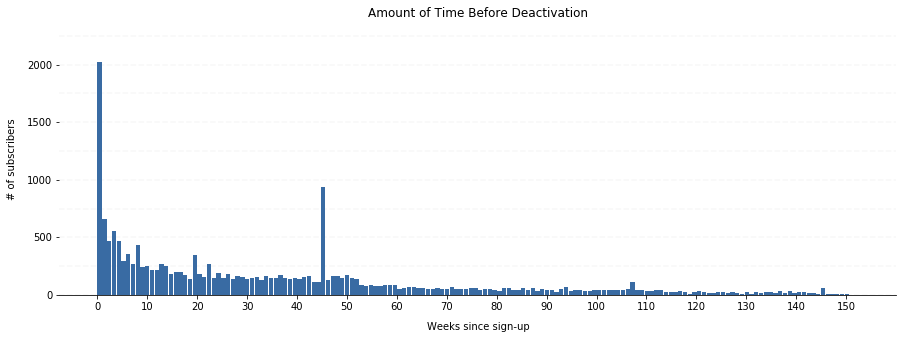

In [104]:
time_before_deactivation = messages[messages['stop'] == 1].groupby('subscriber_id')['subscriber_weeks'].max().reset_index()

ax = time_before_deactivation.hist(column='subscriber_weeks', bins=160, grid=False, figsize=(15,5), color='#396BA3', zorder=2, rwidth=0.9)

ax = ax[0]

for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Amount of Time Before Deactivation")

    # Set x-axis label
    x.set_xlabel("Weeks since sign-up", labelpad=10, size=10)

    # Set y-axis label
    x.set_ylabel("# of subscribers", labelpad=10, size=10)
    
    xticks(range(0,160,10))

# Messages Regression

In [87]:
cols_keep = ['message_id', 'outbound_message_body', 'message_type', 'subscriber_id', 'outbound_message_created_at_adj', 'outbound_message_created_at_day', 'outbound_message_created_at_hour'] + cols
messages_staging = messages[cols_keep]
messages_before_deactivation_24h['pre_deactivation_24h'] = 1
deactivated_staging = messages_before_deactivation_24h[cols_keep + ['pre_deactivation_24h']]
messages_reg = messages_staging.merge(deactivated_staging, how = 'left', left_on = cols_keep, right_on = cols_keep, left_index = True, right_index = False)
messages_reg['pre_deactivation_24h'].fillna(value = 0, inplace = True)
messages_reg.dropna(inplace = True)
messages_reg

,message_id,outbound_message_body,message_type,subscriber_id,outbound_message_created_at_adj,outbound_message_created_at_day,outbound_message_created_at_hour,tag_event,tag_social_connections,tag_knowledge_of_parenting_and_child_development,tag_education_resource,tag_social_and_emotional_competence_of_children,tag_parental_resilience,tag_concrete_support_in_times_of_need,tag_health_resource,tag_other_community_referral_resource,tag_public_service_announcement,tag_COVID_Resources,pre_deactivation_24h
nan,6e92ae11-f983-479f-8e9c-2b689368954d,Invalid zipcode. Kindly check your zipcode and...,signup,53e4abdd-308a-4cfc-a6fc-410c89a28d2d,2017-05-03 11:11:30.588685,Wednesday,11.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,57c0ec0e-f812-4b45-a33a-213f4663f1c2,Is this zipcode correct? If yes reply with 'Y...,signup,f328ee46-398c-422f-aa55-4816caeae06e,2017-05-09 12:34:15.603110,Tuesday,12.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,17d99d4d-137a-4317-b4d8-a63a4690fc93,"If you care for a young child, Bright by Text ...",signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 13:40:41.904659,Thursday,13.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,ffb5de23-d828-4e3a-becf-8b10b80cefba,Unrecognized date of birth format. Please res...,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 13:45:12.364195,Thursday,13.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
nan,bc56c5c2-c5b2-4a95-bfd5-a284661e7052,KLRN welcomes you to Bright by Text! Expect 2 ...,signup,99915cfb-856b-4d59-8b94-0bd26d1342c4,2017-05-04 13:39:17.856495,Thursday,13.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nan,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,Are you worried about paying rent or utilities...,scheduled,ef99f698-0fce-46af-8a36-d6fb1e3019f3,2020-04-02 17:05:25.285664,Thursday,17.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000
nan,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,Are you worried about paying rent or utilities...,scheduled,efa04d9a-bf9e-469f-825a-452fcc0e5754,2020-04-02 17:05:25.463028,Thursday,17.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000
nan,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,Are you worried about paying rent or utilities...,scheduled,f0bf3590-4936-4e67-b4ef-e9e74afccb59,2020-04-02 17:05:26.491638,Thursday,17.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000
nan,f6dfbbbd-1604-4ca8-b1c4-d75709a8641f,Are you worried about paying rent or utilities...,scheduled,f15fc740-2f04-4917-876b-9075009c5af9,2020-04-02 17:05:27.092948,Thursday,17.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000


In [88]:
# Create new variables

messages_reg['sun'] = np.where(messages_reg['outbound_message_created_at_day'] == 'Sunday', 1, 0)
messages_reg['mon'] = np.where(messages_reg['outbound_message_created_at_day'] == 'Monday', 1, 0)
messages_reg['tue'] = np.where(messages_reg['outbound_message_created_at_day'] == 'Tuesday', 1, 0)
messages_reg['wed'] = np.where(messages_reg['outbound_message_created_at_day'] == 'Wednesday', 1, 0)
messages_reg['thu'] = np.where(messages_reg['outbound_message_created_at_day'] == 'Thursday', 1, 0)
messages_reg['fri'] = np.where(messages_reg['outbound_message_created_at_day'] == 'Friday', 1, 0)

messages_reg['12am-8am'] = np.where(messages_reg['outbound_message_created_at_hour'] < 8, 1, 0)
messages_reg['8-10am'] = np.where((messages_reg['outbound_message_created_at_hour'] >= 8) & (messages_reg['outbound_message_created_at_hour'] < 10), 1, 0)
messages_reg['10am-12pm'] = np.where((messages_reg['outbound_message_created_at_hour'] >= 10) & (messages_reg['outbound_message_created_at_hour'] < 12), 1, 0)
messages_reg['12-2pm'] = np.where((messages_reg['outbound_message_created_at_hour'] >= 12) & (messages_reg['outbound_message_created_at_hour'] < 14), 1, 0)
messages_reg['2-4pm'] = np.where((messages_reg['outbound_message_created_at_hour'] >= 14) & (messages_reg['outbound_message_created_at_hour'] < 16), 1, 0)
messages_reg['4-6pm'] = np.where((messages_reg['outbound_message_created_at_hour'] >= 16) & (messages_reg['outbound_message_created_at_hour'] < 18), 1, 0)

In [89]:
messages_reg = messages_reg.drop(columns = ['message_id', 'message_type', 'outbound_message_body', 'subscriber_id', 'outbound_message_created_at_adj', 'outbound_message_created_at_day', 'outbound_message_created_at_hour'])
messages_reg.corr()

,tag_event,tag_social_connections,tag_knowledge_of_parenting_and_child_development,tag_education_resource,tag_social_and_emotional_competence_of_children,tag_parental_resilience,tag_concrete_support_in_times_of_need,tag_health_resource,tag_other_community_referral_resource,tag_public_service_announcement,tag_COVID_Resources,pre_deactivation_24h,sun,mon,tue,wed,thu,fri,12am-8am,8-10am,10am-12pm,12-2pm,2-4pm,4-6pm
tag_event,1.000,0.932,0.509,0.600,0.578,0.249,0.179,0.149,0.046,-0.011,-0.021,0.001,-0.057,0.025,-0.059,0.012,0.028,0.056,0.090,0.174,-0.103,0.082,-0.029,-0.018
tag_social_connections,0.932,1.000,0.480,0.597,0.581,0.208,0.122,0.086,0.106,-0.015,-0.020,0.001,-0.057,0.026,-0.048,0.012,0.019,0.048,0.102,0.173,-0.108,0.076,-0.023,-0.016
tag_knowledge_of_parenting_and_child_development,0.509,0.480,1.000,0.815,0.721,0.511,0.452,0.450,0.165,0.208,0.297,0.001,-0.040,0.023,-0.021,0.059,-0.002,0.020,0.156,0.217,-0.094,0.082,-0.065,-0.023
tag_education_resource,0.600,0.597,0.815,1.000,0.747,0.414,0.291,0.186,0.114,-0.001,0.144,0.001,-0.026,0.021,-0.028,0.034,0.008,0.019,0.103,0.229,-0.081,0.056,-0.052,-0.034
tag_social_and_emotional_competence_of_children,0.578,0.581,0.721,0.747,1.000,0.515,0.370,0.183,0.111,0.022,0.300,0.001,-0.037,0.019,-0.021,0.023,0.005,0.031,0.151,0.215,-0.094,0.060,-0.033,-0.039
tag_parental_resilience,0.249,0.208,0.511,0.414,0.515,1.000,0.691,0.453,0.217,0.116,0.497,-0.000,-0.032,0.017,-0.024,0.059,-0.017,0.022,0.097,0.173,-0.074,0.069,-0.045,0.001
tag_concrete_support_in_times_of_need,0.179,0.122,0.452,0.291,0.370,0.691,1.000,0.547,0.353,0.272,0.468,0.000,-0.036,0.006,-0.010,0.060,-0.020,0.024,0.098,0.127,-0.081,0.088,-0.041,0.019
tag_health_resource,0.149,0.086,0.450,0.186,0.183,0.453,0.547,1.000,0.088,0.021,0.312,0.000,-0.015,0.024,-0.030,0.036,-0.001,0.012,0.097,0.061,-0.057,0.044,-0.029,0.034
tag_other_community_referral_resource,0.046,0.106,0.165,0.114,0.111,0.217,0.353,0.088,1.000,0.254,-0.008,0.001,-0.031,0.000,0.013,0.048,-0.008,-0.006,0.010,0.109,-0.039,0.065,-0.019,-0.024
tag_public_service_announcement,-0.011,-0.015,0.208,-0.001,0.022,0.116,0.272,0.021,0.254,1.000,0.086,-0.000,-0.020,-0.023,0.011,0.061,-0.015,0.002,0.028,0.005,-0.026,0.090,-0.049,0.015


In [90]:
# Drop tags that are highly correlated with each other

dropped = ['tag_event', 'tag_social_connections', 'tag_education_resource', 'tag_social_and_emotional_competence_of_children', 'tag_parental_resilience', 'tag_health_resource', 'tag_COVID_Resources']
messages_reg = messages_reg.drop(columns = dropped)

In [91]:
# Output to Excel (outputting 1M rows in each csv file)

messages_dict = {}

for i in range(0, 16000000, 1000000):
    messages_dict[i] = messages_reg.iloc[i:i+999999]

messages_dict[16000000] = messages_reg.iloc[16000000:]

for i in range(0, 17000000, 1000000):
    messages_dict[i].to_csv(r'/Users/lisafan/Desktop/BBT/messages_reg_' + str(i) + '.csv', index = False)  

# Follow-Ups for BBT

## Subscribers that Deactivated at 45 Weeks

In [229]:
subscribers_45_weeks = subscribers[(subscribers['stop'] == 1) & (subscribers['subscriber_weeks'] >= 45) & (subscribers['subscriber_weeks'] < 46)]

In [234]:
# Export to Excel

subscribers_45_weeks.to_csv(r'/Users/lisafan/Desktop/BBT/45_week_subscribers.csv')  

In [230]:
subscribers_45_weeks_staging = pd.DataFrame(subscribers_45_weeks['subscriber_id']).merge(messages, how = 'left', left_on = 'subscriber_id', right_on = 'subscriber_id', left_index = True, right_index = False)
subscribers_45_weeks_staging = subscribers_45_weeks_staging.groupby('subscriber_id')[['subscriber_weeks', 'created_at_adj', 'deactivated_at_adj']].max().reset_index()
subscribers_45_weeks_staging

,subscriber_id,subscriber_weeks,created_at_adj,deactivated_at_adj
0,00079148-20c5-44a2-aa40-8f50133e3b19,45.009,2017-06-19 07:17:42.208957,2018-04-30 08:50:47.336639
1,0018617f-4cdf-42b4-909e-96af52ffddae,45.009,2017-06-19 07:15:19.698238,2018-04-30 08:50:43.901832
2,002aacd6-4b1e-4854-9a7c-9ba28488c3d3,45.009,2017-06-19 07:18:04.845262,2018-04-30 08:50:48.234189
3,00de8ab4-addb-4273-8cc6-26690e69430c,45.016,2017-06-19 06:05:44.251781,2018-04-30 08:49:20.991308
4,00f4fdb0-fbcf-40fd-bd9e-e27b5edbb862,45.012,2017-06-19 06:47:04.688026,2018-04-30 08:50:19.400351
...,...,...,...,...
931,fe7eeccd-22cc-4f28-a2b8-f72b125a5cf7,45.011,2017-06-19 07:01:30.250219,2018-04-30 08:50:26.632277
932,feb474a8-50ed-4f58-aa22-c753246afa30,45.013,2017-06-19 06:36:38.315019,2018-04-30 08:49:58.401153
933,ff759819-edad-49b9-bbe7-69d4f060bb07,45.020,2017-06-19 05:27:10.366285,2018-04-30 08:48:32.564015
934,ffc7c377-51d3-450f-b284-33d207536b2b,45.015,2017-06-19 06:22:44.693563,2018-04-30 08:49:40.984469


In [231]:
subscribers_45_weeks_staging['created_date'] = subscribers_45_weeks_staging['created_at_adj'].dt.date
subscribers_45_weeks_staging['deactivated_date'] = subscribers_45_weeks_staging['deactivated_at_adj'].dt.date

In [232]:
subscribers_45_weeks_staging['created_date'].value_counts()

2017-06-19    802
2017-06-16     16
2017-06-12     13
2017-06-14     13
2017-06-15     12
2017-06-13      8
2017-06-18      5
2017-06-17      4
2019-05-17      4
2018-03-05      2
2018-01-09      1
2019-01-03      1
2019-04-03      1
2018-02-14      1
2018-10-14      1
2018-11-05      1
2018-09-19      1
2019-01-02      1
2018-02-04      1
2017-12-29      1
2017-08-15      1
2018-11-14      1
2018-08-17      1
2017-09-05      1
2019-05-03      1
2017-10-06      1
2018-02-21      1
2017-08-18      1
2018-12-19      1
2018-02-26      1
2017-11-27      1
2018-01-08      1
2018-07-29      1
2017-08-05      1
2019-01-22      1
2017-12-15      1
2018-05-20      1
2019-01-25      1
2018-10-23      1
2018-05-22      1
2017-09-14      1
2018-05-29      1
2019-04-30      1
2018-02-17      1
2019-01-27      1
2019-01-30      1
2017-12-06      1
2019-05-23      1
2018-01-15      1
2018-03-03      1
2018-06-30      1
2017-07-19      1
2019-02-19      1
2018-12-05      1
2018-03-06      1
2017-08-01

In [233]:
subscribers_45_weeks_staging['deactivated_date'].value_counts()

2018-04-30    863
2018-05-04      4
2018-05-01      3
2018-05-03      2
2018-07-03      2
2020-04-24      2
2018-05-02      2
2019-01-06      2
2019-04-05      2
2020-01-03      1
2018-07-21      1
2019-09-19      1
2019-07-01      1
2019-12-15      1
2018-12-27      1
2018-10-29      1
2019-01-02      1
2018-08-18      1
2019-12-05      1
2019-08-28      1
2018-11-25      1
2018-06-06      1
2019-06-13      1
2020-03-27      1
2019-12-13      1
2020-03-14      1
2018-06-14      1
2020-02-14      1
2018-10-19      1
2018-11-11      1
2020-01-19      1
2019-09-01      1
2018-11-26      1
2019-11-17      1
2019-09-03      1
2019-01-17      1
2019-01-18      1
2019-10-17      1
2018-06-04      1
2019-01-14      1
2019-08-04      1
2018-10-13      1
2020-05-07      1
2019-04-14      1
2018-07-28      1
2019-11-06      1
2018-10-23      1
2019-12-18      1
2020-04-28      1
2019-04-25      1
2019-01-21      1
2020-02-04      1
2018-07-12      1
2018-12-01      1
2018-06-18      1
2019-05-17

# Next Steps

- Get answers to questions from BBT
- Provide BBT with data file of subscribers that deactivated at 45 weeks
- Provide BBT with data file of messages tagged “Other community referral” with relatively high STOP rates
- Provide BBT with data file of messages that went out between 12am and 8am local time with relatively high STOP rates
- Refine regressions
- Check what regressions look like if you exclude mid-day hours
- Zip codes with highest and lowest median frequency of messages sent
- Save analysis and regression code to Github